## **Tech Challenge - FASE 02**

## Projeto: Previsão de Tendência do Ibovespa com Séries Temporais


---



## **1-Problema**

Você foi recentemente alocado em uma equipe de cientistas de dados de um grande fundo de investimentos brasileiro. Sua missão inicial é desenvolver um modelo preditivo capaz de prever se o índice IBOVESPA vai fechar em alta ou baixa no dia seguinte, com base em dados históricos do próprio índice. Esse modelo será usado como insumo para alimentar dashboards internos de tomada de decisão dos analistas quantitativos da empresa.

## **2- Sobre os Dados**

**Data** => Dia da negociação na bolsa.

**Último** => Valor de fechamento do Ibovespa no final do pregão (última cotação do dia).

**Abertura** => Valor do Ibovespa no início do pregão.

**Máxima** => Maior valor atingido pelo índice durante o dia.

**Mínima** => Menor valor atingido pelo índice durante o dia.

**Vol.** => Volume financeiro negociado no dia (em milhões ou bilhões de reais).

**Var%** => Variação percentual do índice em relação ao dia anterior.

## **3- Aquisição e Exploração dos Dados**

Instalar e importar as bibliotecas necessárias

In [ ]:

!pip install "pandas>=2.0.0"
!pip install tensorflow
!pip install xgboost


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Leitura da base de dados - dados históricos do índice IBOVESPA, disponíveis publicamente: https://br.investing.com/indices/bovespa-historical-data

Requisitos:
• Período selecionado: “diário”;
• Intervalo de 01/01/2018 até 10/08/2025.

In [ ]:
df = pd.read_csv('/content/Dados Históricos - Ibovespa 01-01-18 a 10-08-25.csv', parse_dates=[0], index_col="Data", dayfirst=True)
# Sort the DataFrame by the index (Date) to ensure chronological order
df = df.sort_index()

Visualização das primeiras e das últimas linhas do dataframe (df) gerado após a leitura da base de dados

In [ ]:
df.head()

,Último,Abertura,Máxima,Mínima,Vol.,Var%
Data,,,,,,
2018-01-02,77.891,76.403,77.909,76.403,"2,97M","1,95%"
2018-01-03,77.995,77.889,78.414,77.602,"3,24M","0,13%"
2018-01-04,78.647,77.998,79.135,77.998,"3,59M","0,84%"
2018-01-05,79.071,78.644,79.071,78.218,"2,83M","0,54%"
2018-01-08,79.379,79.070,79.395,78.631,"2,63M","0,39%"


In [ ]:
df.tail()

,Último,Abertura,Máxima,Mínima,Vol.,Var%
Data,,,,,,
2025-08-04,132.971,132.440,133.929,132.440,"6,14B","0,40%"
2025-08-05,133.151,132.971,134.233,132.682,"6,61B","0,14%"
2025-08-06,134.538,133.169,135.241,133.169,"8,68B","1,04%"
2025-08-07,136.528,134.538,137.007,134.533,"9,50B","1,48%"
2025-08-08,135.913,136.526,136.761,135.659,"9,89B","-0,45%"


Visualização das informações sobre o df

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1889 entries, 2018-01-02 to 2025-08-08
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Último    1889 non-null   float64
 1   Abertura  1889 non-null   float64
 2   Máxima    1889 non-null   float64
 3   Mínima    1889 non-null   float64
 4   Vol.      1889 non-null   object 
 5   Var%      1889 non-null   object 
dtypes: float64(4), object(2)
memory usage: 103.3+ KB


In [ ]:
df.shape

(1889, 6)

Verificamos se há algum dado nulo no df e somamos todos as linhas que são nulas por coluna

In [ ]:
df.isnull().sum()

,0
Último,0
Abertura,0
Máxima,0
Mínima,0
Vol.,0
Var%,0


Verificamos se há algum dado duplicado no df e somamos todos as linhas que são nulas por coluna

In [ ]:
df.duplicated().sum()

np.int64(0)

Para que as colunas 'Vol.' (Volume) e 'Var%' (Variação Percentual) possam ser utilizadas em análises e no modelo, é necessário limpar seus dados. Atualmente, elas contêm caracteres como 'B', 'M', 'K' e '%', além de vírgulas como separadores decimais, o que impede a conversão direta para um formato numérico adequado. O código a seguir realiza essa limpeza.

In [ ]:
# Limpeza de colunas
def clean_volume(vol_str):
    vol_str = str(vol_str).replace(',', '.')
    if 'B' in vol_str:
        return float(vol_str.replace('B', '')) * 1e9
    elif 'M' in vol_str:
        return float(vol_str.replace('M', '')) * 1e6
    elif 'K' in vol_str:
        return float(vol_str.replace('K', '')) * 1e3
    else:
        return float(vol_str)

df['Vol.'] = df['Vol.'].apply(clean_volume)
df['Var%'] = df['Var%'].replace('%', '', regex=True).str.replace(',', '.').astype(float)

In [ ]:
# Visualizar amostra
df.head()

,Último,Abertura,Máxima,Mínima,Vol.,Var%
Data,,,,,,
2018-01-02,77.891,76.403,77.909,76.403,2970000.0,1.95
2018-01-03,77.995,77.889,78.414,77.602,3240000.0,0.13
2018-01-04,78.647,77.998,79.135,77.998,3590000.0,0.84
2018-01-05,79.071,78.644,79.071,78.218,2830000.0,0.54
2018-01-08,79.379,79.070,79.395,78.631,2630000.0,0.39


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1889 entries, 2018-01-02 to 2025-08-08
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Último    1889 non-null   float64
 1   Abertura  1889 non-null   float64
 2   Máxima    1889 non-null   float64
 3   Mínima    1889 non-null   float64
 4   Vol.      1889 non-null   float64
 5   Var%      1889 non-null   float64
dtypes: float64(6)
memory usage: 103.3 KB


### **Histórico do Ibovespa**

Para iniciar nossa análise exploratória, visualizamos a evolução do preço de fechamento do Ibovespa ao longo do período de 01/01/2018 a 10/08/2025. Este gráfico nos oferece uma perspectiva imediata sobre o comportamento histórico do índice.
Podemos observar uma tendência geral de alta ao longo dos anos, indicando uma valorização do índice no longo prazo, apesar das flutuações inerentes ao mercado.
O gráfico também evidencia a volatilidade do Ibovespa, com períodos de movimentos mais acentuados, refletindo a dinâmica e as incertezas do cenário econômico e político.
Esta visualização inicial é crucial para compreendermos a dinâmica da série temporal do Ibovespa e identificar padrões que serão importantes para a modelagem preditiva.

In [ ]:
df_ultimo = df[["Último"]]

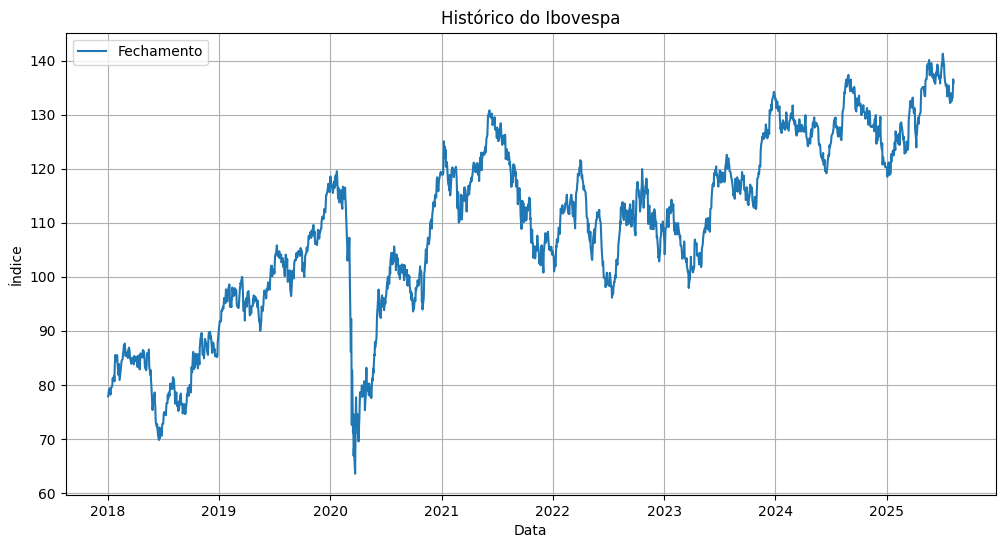

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Último'], label='Fechamento')
plt.title('Histórico do Ibovespa')
plt.xlabel('Data')
plt.ylabel('Índice')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Criar coluna de tendência (Target)
df['Target'] = (df['Último'].shift(-1) > df['Último']).astype(int)

Adicionar a coluna 'Target' ao DataFrame df e garantir que seja do tipo inteiro.

In [ ]:
# Transformar e garantir tipo
df_long = (
    df.assign(Target=df["Target"].astype(int))
      .melt(id_vars=["Target"],
            value_vars=["Abertura", "Máxima", "Mínima", "Último"],
            var_name="Tipo", value_name="Valor")
)

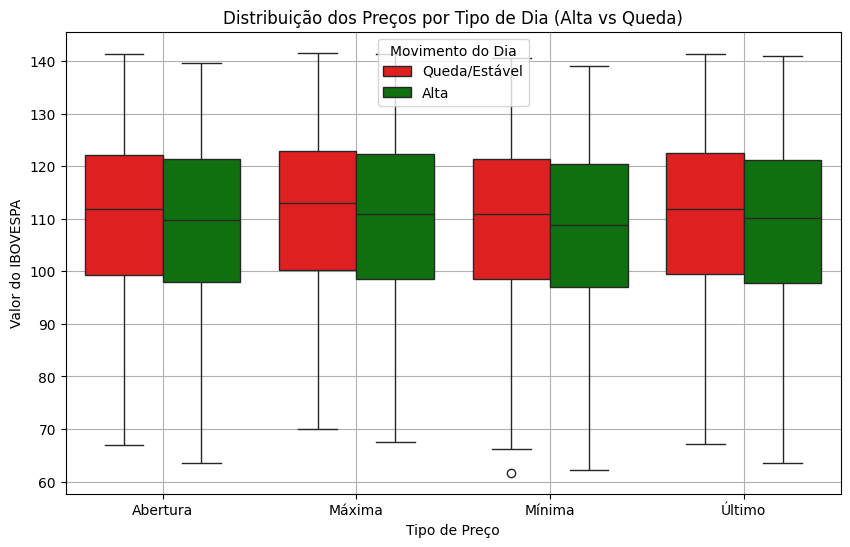

In [ ]:
# Criar o boxplot
plt.figure(figsize=(10, 6))
ax = sns.boxplot(
    data=df_long,
    x="Tipo",
    y="Valor",
    hue="Target",
    palette={0: "red", 1: "green"}
)

# Ajustar legenda corretamente
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ["Queda/Estável", "Alta"], title="Movimento do Dia")

plt.title("Distribuição dos Preços por Tipo de Dia (Alta vs Queda)")
plt.ylabel("Valor do IBOVESPA")
plt.xlabel("Tipo de Preço")
plt.grid()
plt.show()


O boxplot resultante compara visualmente a distribuição dos preços de 'Abertura', 'Máxima', 'Mínima' e 'Último' para os dias em que o Ibovespa fechou em alta (Alta - verde) versus os dias em que fechou em baixa ou estável (Queda/Estável - vermelho). Isso ajuda a entender como o intervalo e a mediana desses preços diferem com base no movimento do mercado no dia seguinte.

## **4- Análise Exploratória (EDA)**

**4.1 - Decomposição sazonal - seasonal_decompose**

A decomposição sazonal do Ibovespa nos permite abrir a série temporal em “camadas” para entender melhor como o índice se comporta ao longo do tempo. O gráfico é dividido em quatro partes:

**Observed (Observado)**

O primeiro painel mostra a série original da coluna "Último", ou seja, o preço de fechamento diário do Ibovespa exatamente como registrado nos dados. Aqui vemos todas as oscilações, misturando tendências, padrões cíclicos e ruídos.

**Trend (Tendência)**

O segundo painel destaca o movimento de longo prazo, suavizando ruídos e ciclos curtos. Ele revela a direção predominante do índice — períodos de valorização sustentada (tendência de alta), quedas prolongadas ou momentos de lateralização.

**Seasonal (Sazonalidade)**

O terceiro painel isola padrões que se repetem em intervalos regulares, definidos pelo parâmetro period. No exemplo com period=12, estamos capturando ciclos que se repetem aproximadamente a cada 12 dias úteis, o que pode não refletir uma sazonalidade típica do mercado (geralmente anual ou semanal). Ajustar o período para 252 — o número aproximado de pregões em um ano — permitiria observar um padrão médio anual de comportamento.

**Residual (Resíduo)**

O último painel mostra o que sobra após remover tendência e sazonalidade: o ruído. São variações imprevisíveis, muitas vezes associadas a eventos pontuais ou volatilidade de curto prazo. Quando esse resíduo se distribui de forma aleatória em torno de zero, significa que os principais padrões foram bem capturados pelos outros componentes.

Essa decomposição ajuda a separar o que é movimento estrutural, o que é padrão recorrente e o que é imprevisível, facilitando tanto a análise quanto a modelagem preditiva.

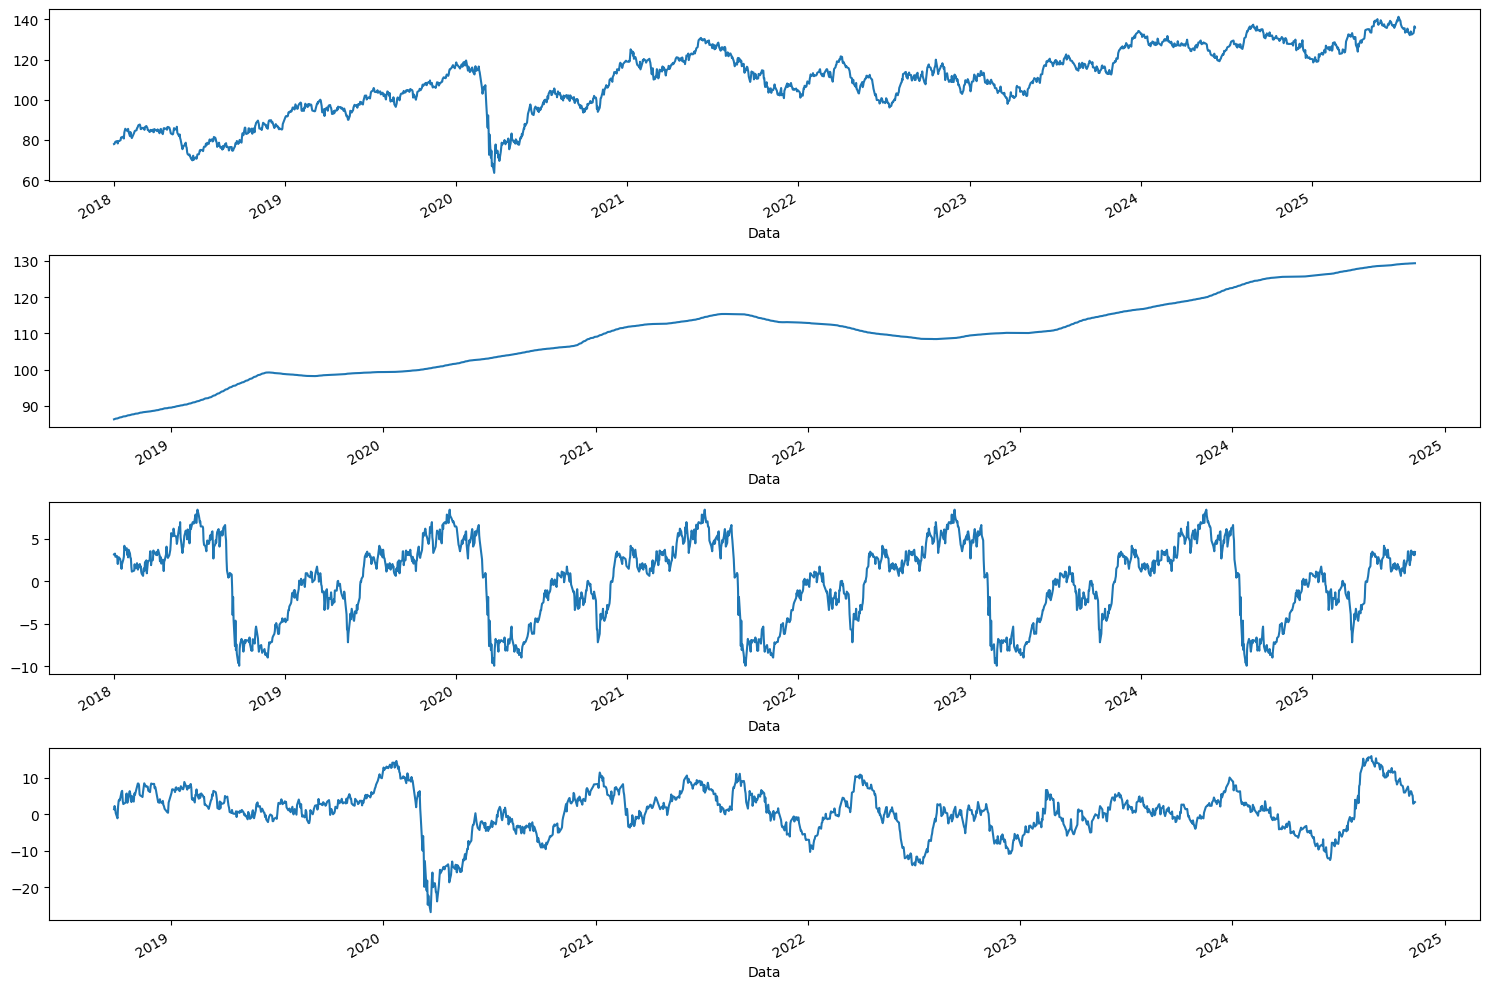

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

resultado = seasonal_decompose(df_ultimo, period=365)
# Representação gráfica da decomposição da série temporal

fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize = (15,10))

resultado.observed.plot(ax=ax1) #observado
resultado.trend.plot(ax=ax2) #tendência
resultado.seasonal.plot(ax=ax3) #sazonalidade
resultado.resid.plot(ax=ax4) #resíduo

plt.tight_layout()

**4.2 - Série temporal: Estacionária ou Não Estacionária?**

Executamos o teste Augmented Dickey-Fuller (ADF) na série temporal dos dados da coluna 'Último' para verificar se a série é estacionária.

In [ ]:
sns.set_style('darkgrid')

In [ ]:
x = df_ultimo.Último.values

In [ ]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(x)

print("Teste ADF")
print(f"Teste Estatístico: {result[0]}")
print(f"P-value: {result[1]}")
print("Valores críticos:")

for key, value in result[4].items():
    print(f"\t{key}: {value}")


if result[1] < 0.05:
    print("Série estacionária")
else:
    print("Série não estacionária")

Teste ADF
Teste Estatístico: -2.1452645257037926
P-value: 0.22670710817459777
Valores críticos:
	1%: -3.433833112339179
	5%: -2.8630785975831463
	10%: -2.5675890926324128
Série não estacionária


O Teste ADF determinou que a série temporal é uma Série Não Estacionária.

Essa definição é feita de acordo o valor do p-value. Se o p-value for menor que 0.05 (nível de significância), rejeitamos a hipótese nula (H0). A hipótese nula do teste ADF é que a série temporal não é estacionária. Portanto, se o p-value for menor que 0.05, concluímos que a série é estacionária. Caso contrário, se o p-value for maior ou igual a 0.05, não rejeitamos a hipótese nula e concluímos que a série não é estacionária.

No teste ADF do nosso notebook, o p-value foi de aproximadamente 0.227 (ou 22.7%). Como 0.227 é maior que 0.05, não rejeitamos a hipótese nula de que a série não é estacionária. Por isso, concluímos que a série do Ibovespa é não estacionária.

**4.3 - Análise da Evolução do Preço de Abertura com Média Móvel (12 dias)**

📈O gráfico abaixo mostra a evolução da variável "Abertura" do índice IBOVESPA entre os anos de 2018 e 2025, acompanhada de uma Média Móvel Simples (SMA) de 12 dias. Embora a série cubra um longo período, a média móvel aplicada tem como foco o curto prazo, suavizando pequenas oscilações diárias.

No gráfico:

A linha azul representa os valores reais de Abertura registrados diariamente;

A linha vermelha mostra a média móvel de 12 dias, revelando pequenas tendências locais no meio de um contexto temporal mais amplo.

Esta visualização permite identificar padrões de curto prazo dentro de uma perspectiva de longo prazo, sendo especialmente útil para observar momentos de aceleração, desaceleração ou reversão no comportamento do mercado.

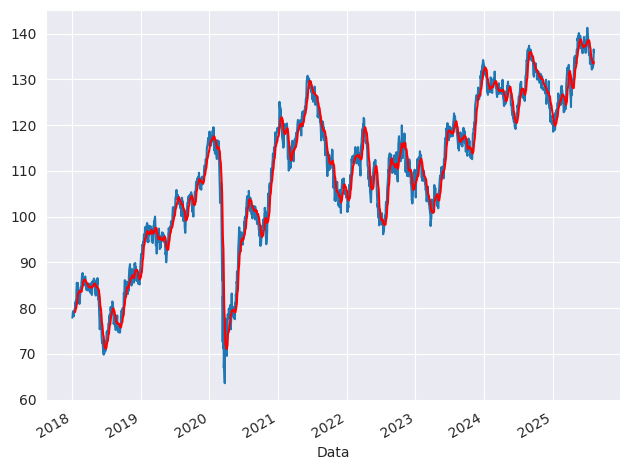

In [ ]:
ma = df_ultimo.rolling(12).mean() # média móvel

f, ax = plt.subplots()
df_ultimo.plot(ax=ax, legend=False)
ma.plot(ax=ax, legend=False, color='r')
plt.tight_layout()

**4.4 - Série Temporal (Escala Logarítmica) com Média Móvel (12 dias)**

Fizemos uma transformação logarítmica na série temporal dos valores de fechamento do Ibovespa ('Último') e calculamos a média móvel de 12 dias sobre essa série logarítmica.

O gráfico resultante mostra a série temporal do Ibovespa em escala logarítmica (linha azul) e sua média móvel de 12 dias (linha vermelha). Essa visualização ajuda a observar a tendência e os ciclos na série após a aplicação da transformação logarítmica.

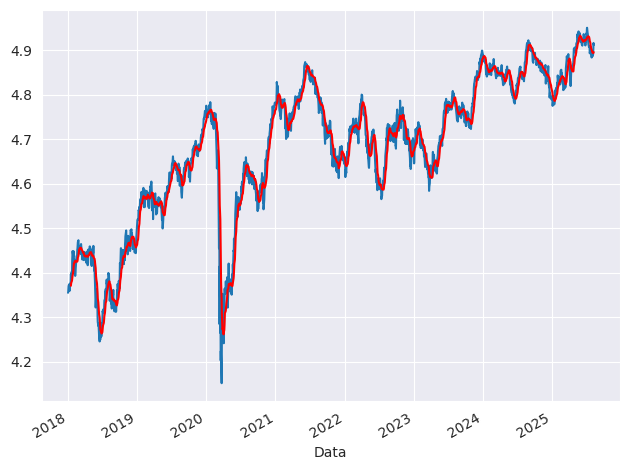

In [ ]:
df_log = np.log(df_ultimo)
ma_log = df_log.rolling(12).mean()

f, ax = plt.subplots()
df_log.plot(ax=ax, legend=False)
ma_log.plot(ax=ax, legend=False, color='r')
plt.tight_layout()

**4.5 - Série Temporal (Escala Logarítmica e Sem Tendência) com Média Móvel e Desvio Padrão**

Subtraímos a média móvel logarítmica da série logarítmica original para remover a tendência de curto prazo e, em seguida, calculamos a média móvel e o desvio padrão da série resultante. E plotamos essas três séries.

O gráfico abaixo ajuda a visualizar a série após a remoção da tendência de curto prazo, a média móvel da série (que idealmente deve ser plana e próxima de zero para uma série estacionária) e a volatilidade móvel.

É um passo importante na análise de séries temporais para identificar se a série se tornou estacionária após as transformações.

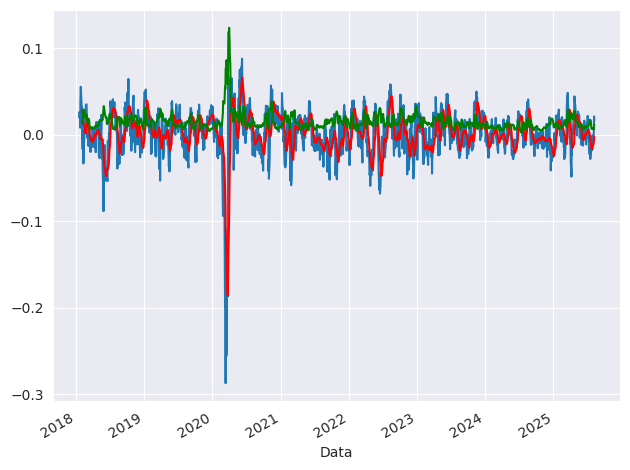

In [ ]:
df_s = (df_log - ma_log).dropna()

ma_s = df_s.rolling(12).mean()

std = df_s.rolling(12).std()

f, ax = plt.subplots()
df_s.plot(ax=ax, legend=False)
ma_s.plot(ax=ax, legend=False, color='r')
std.plot(ax=ax, legend=False, color='g')
plt.tight_layout()

Executamos novamente o teste Augmented Dickey-Fuller (ADF), mas desta vez na série temporal df_s, que é a série do preço de fechamento do Ibovespa após aplicar a transformação logarítmica e remover a tendência de curto prazo.

O objetivo de executar o teste ADF nesta série transformada é verificar se as etapas de transformação logarítmica e remoção da tendência foram suficientes para tornar a série estacionária.

In [ ]:
x_s = df_s.Último.values
result_s = adfuller(x_s)

print("Teste ADF")
print(f"Teste Estatístico: {result_s[0]}")
print(f"P-value: {result_s[1]}")
print("Valores críticos:")

for key, value in result_s[4].items():
    print(f"\t{key}: {value}")

if result_s[1] < 0.05:
    print("Série estacionária")
else:
    print("Série não estacionária")

Teste ADF
Teste Estatístico: -10.983312127341918
P-value: 7.365038322462234e-20
Valores críticos:
	1%: -3.433851764270508
	5%: -2.863086831883029
	10%: -2.5675934770796993
Série estacionária


Realizamos a diferenciação da série temporal, calculamos a média móvel e o desvio padrão da série diferenciada e, em seguida, executamos o teste ADF nela para verificar a estacionaridade.

Os resultados do teste ADF mostraram que a série diferenciada agora é estacionária (p-value muito baixo). O gráfico também sugere isso, pois a média e o desvio padrão parecem mais constantes ao longo do tempo.

Teste ADF
Teste Estatístico: -13.507783361374488
P-value: 2.8926911326599057e-25
Valores críticos:
	1%: -3.433887758938708
	5%: -2.8631027223655448
	10%: -2.567601938172921
Série estacionária


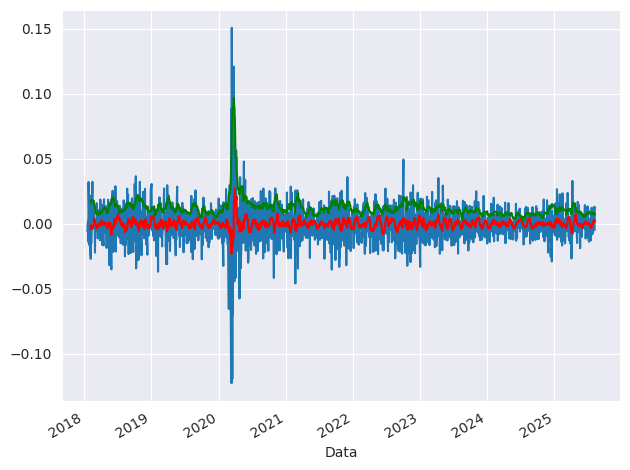

In [ ]:
df_diff = df_s.diff(1)
ma_diff = df_diff.rolling(12).mean()

std_diff = df_diff.rolling(12).std()

f, ax = plt.subplots()
df_diff.plot(ax=ax, legend=False)
ma_diff.plot(ax=ax, legend=False, color='r')
std_diff.plot(ax=ax, legend=False, color='g')
plt.tight_layout()

x_diff = df_diff.Último.dropna().values
result_diff = adfuller(x_diff)

print("Teste ADF")
print(f"Teste Estatístico: {result_diff[0]}")
print(f"P-value: {result_diff[1]}")
print("Valores críticos:")

for key, value in result_diff[4].items():
    print(f"\t{key}: {value}")

if result_diff[1] < 0.05:
    print("Série estacionária")
else:
    print("Série não estacionária")

Calculamos e armazenamos as funções de autocorrelação (ACF) e autocorrelação parcial (PACF) para a série temporal diferenciada (df_diff)

In [ ]:
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(df_diff.dropna(), nlags=360)
lag_pacf = pacf(df_diff.dropna(), nlags=360, method='yw')

Os resultados desses cálculos (lag_acf e lag_pacf) são arrays NumPy que contêm os valores da ACF e PACF para cada lag, respectivamente. Estes resultados serão usados nos próximos passos para plotar os gráficos de ACF e PACF, que são ferramentas visuais essenciais na identificação dos parâmetros (p e q) para os modelos.

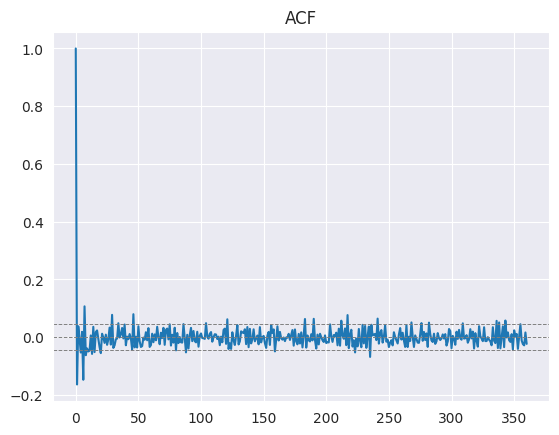

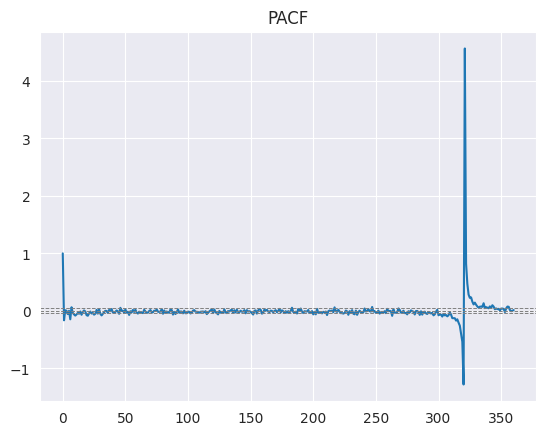

In [ ]:
#5% ACF
plt.plot(lag_acf)
plt.axhline(y= -1.96/(np.sqrt((len(df_diff) -1))), linestyle="--", color="gray", linewidth=0.7)
plt.axhline(y= 0, linestyle="--", color="gray", linewidth=0.7)
plt.axhline(y= 1.96/(np.sqrt((len(df_diff) -1))), linestyle="--", color="gray", linewidth=0.7)

plt.title("ACF")
plt.show()

plt.plot(lag_pacf)
plt.axhline(y= -1.96/(np.sqrt((len(df_diff) -1))), linestyle="--", color="gray", linewidth=0.7)
plt.axhline(y= 0, linestyle="--", color="gray", linewidth=0.7)
plt.axhline(y= 1.96/(np.sqrt((len(df_diff) -1))), linestyle="--", color="gray", linewidth=0.7)

plt.title("PACF")
plt.show()

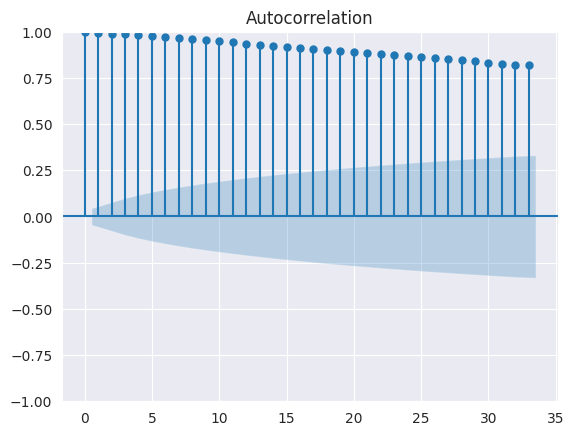

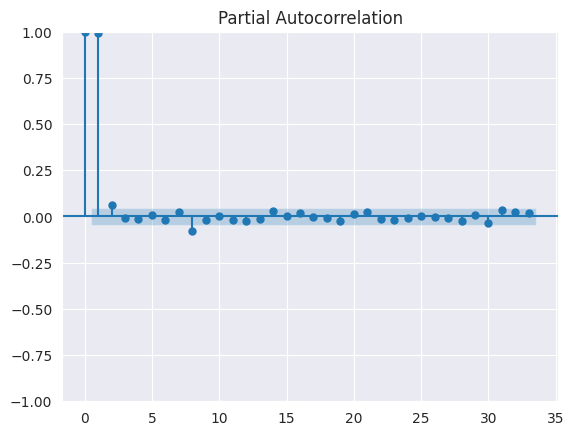

In [ ]:
#plotar os gráficos ACF e PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df_ultimo.Último)
plot_pacf(df_ultimo.Último)
plt.show()

4.6 - **Histograma com KDE**

Este histograma com KDE mostra a distribuição dos valores de fechamento do Ibovespa ('Último') ao longo do período analisado. Observamos que a distribuição não é unimodal (com um único pico), mas sim bimodal, apresentando um pico principal na faixa de valores mais altos (acima de 110.000) e um pico secundário em valores significativamente mais baixos. A presença desse segundo pico em valores baixos pode indicar a existência de outliers ou a necessidade de uma revisão mais aprofundada da escala ou da limpeza dos dados em alguns pontos, mesmo após os ajustes já realizados.

<Axes: xlabel='Último', ylabel='Count'>

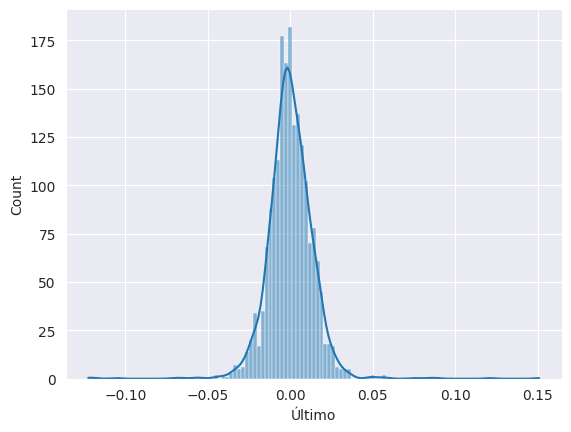

In [ ]:
sns.histplot(data=df_diff, x="Último", kde=True)

## **5- Engenharia de Atributos**

A seção de Engenharia de Atributos é crucial para criar novas variáveis (features) a partir dos dados brutos que possam ajudar o modelo a aprender padrões e fazer previsões.

Aqui está a explicação de cada etapa:

1- Médias Móveis (Moving Averages - MM_5 e MM_10):

*   MM_5 - Calcula a média móvel do preço de fechamento (Último) para uma janela de 5 dias. Essa média móvel suaviza a série temporal e ajuda a identificar a direção da tendência de curto prazo. Para cada dia, a MM_5 é a média dos preços de fechamento dos últimos 5 dias (incluindo o dia atual).

*   MM_10 - Calcula a média móvel do preço de fechamento para uma janela de 10 dias. Uma média móvel de 10 dias é mais lenta para reagir a mudanças de preço do que a de 5 dias e é usada para observar a tendência de médio prazo.

Propósito: Médias móveis são indicadores técnicos comuns que ajudam a identificar tendências e potenciais pontos de suporte ou resistência. Ao incluí-las como features, estamos dando ao modelo informações sobre a dinâmica recente do preço.

2- Variação Percentual Diária (Retorno): Calcula a variação percentual do preço de fechamento de um dia para o outro.

Propósito: O retorno diário é uma métrica fundamental em finanças que mostra a performance percentual do ativo em um dia. É uma medida de volatilidade e direção do movimento de preço. Incluir o retorno ajuda o modelo a entender a magnitude e a direção das mudanças de preço recentes. Note que o primeiro valor será NaN (Não é um Número), pois não há um dia anterior para calcular a variação.

3- Criar Coluna de Tendência (Target): Esta é a criação da sua variável alvo, que você quer prever. Deslocamos a coluna 'Último' uma posição para cima. Isso significa que, para cada linha, teremos o preço de fechamento do dia seguinte.

Também comparamos o preço de fechamento do dia seguinte com o preço de fechamento do dia atual. O resultado foi uma série de valores booleanos (True ou False). Será True se o preço de fechamento do dia seguinte for maior que o do dia atual (indicando alta), e False caso contrário (indicando baixa ou estabilidade).

Convertemos os valores booleanos para inteiros: True se torna 1 e False se torna 0.

Propósito: Esta coluna 'Target' é a variável que queremos prever com o nosso modelo. Target = 1 significa que o Ibovespa fechou em alta no dia seguinte, e Target = 0 significa que ele fechou em baixa ou no mesmo patamar. É a binarização do movimento de preço para a sua tarefa de classificação.

Conclusão: Em suma, a engenharia de atributos criou variáveis que capturam a tendência de médio/curto prazo (Médias Móveis), a volatilidade e a direção da mudança diária (Retorno), e a variável que queremos prever (Target), baseada no movimento do dia seguinte. Essas novas features fornecem ao modelo informações mais ricas do que apenas os preços brutos para realizar a previsão.

In [ ]:
#criar um novo DataFrame vazio
dataset = pd.DataFrame()

In [ ]:
#criar a coluna "Último"
dataset["Último"] = df["Último"]

#calcula a diferença entre o preço de fechamento de cada dia e o preço de fechamento do dia anterior no DataFrame original df
delta = df['Último'].diff()

#Define um limite (threshold) de 0.003. Usado para determinar se uma variação percentual é considerada uma "alta" significativa para a criação da variável Target
threshold = 0.003  # desconsiderando variações menores que 0.3%
dataset['Target'] = (delta > threshold).astype(int)  # 1 se a variação for maior que o threshold, 0 caso contrário

#remove a última linha, pois o alvo para o último dia não está disponível
dataset = dataset[:-1]

#cria duas novas colunas no seu DataFrame dataset, baseadas nos valores do dia anterior
dataset["Delta"] = delta.shift(1)
dataset['Retorno'] = dataset['Último'].pct_change().shift(1)

In [ ]:
#funções agregadoras

def make_lags(series: pd.Series, n_lags):
    return series.shift(n_lags)


def make_n_lags(df, n_lags, column):
    for i in range(1, n_lags + 1):
        df[f"{column}_lag{i}"] = df[column].shift(i)
    return df

def compute_rsi(series, period=14):
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)

    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def compute_macd(series, fast=12, slow=26, signal=9):
    exp1 = series.ewm(span=fast, adjust=False).mean()
    exp2 = series.ewm(span=slow, adjust=False).mean()
    macd = exp1 - exp2
    signal_line = macd.ewm(span=signal, adjust=False).mean()
    return macd, signal_line

def compute_bollinger(series, window=20, num_std=2):
    ma = series.rolling(window=window).mean()
    std = series.rolling(window=window).std()
    upper = ma + num_std * std
    lower = ma - num_std * std
    return upper, lower

In [ ]:
#criar N lags de 1 a N
n_lags = 30

#remova após os lags serem criados
dataset = make_n_lags(dataset, n_lags, "Delta")

# Explicação das Features Criadas

As variáveis extraídas do dataset foram construídas para capturar diferentes dimensões do comportamento do ativo.  
Cada grupo de features conta uma parte da “história” do mercado:

---

### 1. Extremos do Preço
- **Máxima, Mínima (diff + shift):** Capturam como os extremos mudam dia a dia, refletindo o humor do mercado.  
- **Spread:** Diferença entre máxima e mínima, mostrando a batalha entre compradores e vendedores.

---

### 2. Volatilidade
- **Volatilidade (10D std):** Batimento cardíaco do mercado no curto prazo.  
- **TR & ATR (True Range e Average True Range):** Pressão intradiária, considerando gaps e alongamentos.  
- **Volatilidades 10D, 22D, 66D:** Diferentes horizontes de oscilação (curto, médio e longo prazo).  
- **Historical Volatility (20D, 60D):** Variabilidade histórica baseada nos retornos diários.

---

### 3. Abertura e Volume
- **Abertura (diff):** Mostra gaps de expectativas entre dias.  
- **Volume (diff):** Mudança no interesse dos investidores.  
- **Volume_MM20:** Tendência do volume ao longo do tempo.

---

### 4. Indicadores de Tendência e Momentum
- **Momentum (5D):** Impulso de curtíssimo prazo.  
- **Médias móveis (5 a 200 dias):** Tendências de diferentes horizontes, de curto a secular.  
- **MACD & Signal:** Conflito entre curto e longo prazo; cruzamentos indicam potenciais reversões.

---

### 5. Indicadores de Sentimento
- **RSI (14D):** Termómetro da fadiga do mercado (sobrecompra/sobrevenda).  
- **Bandas de Bollinger:** Funcionam como elásticos que prendem o preço, sinalizando pressões e possíveis reversões.

---

### 6. Retornos
- **Return_5D, Return_10D, Return_20D:** Retornos acumulados em diferentes horizontes, memória recente do mercado.  
- **Daily_Return:** Variação diária do preço.

---

### Resumo
As features criadas funcionam como uma **crónica da vida do ativo**:
- Captam **curto prazo** (momentum, volatilidade curta, retornos recentes).  
- Revelam o **médio/longo prazo** (MA200, volatilidade histórica).  
- Expõem o **sentimento e emoção do mercado** (RSI, MACD, Volume).  

No conjunto, elas ajudam o modelo a distinguir períodos de calma e períodos de tempestade.


In [ ]:
#utilizamos o .diff() como recurso de estacionarização
dataset["Máxima"] = df["Máxima"].diff().shift(1)
dataset["Mínima"] = df["Mínima"].diff().shift(1)

dataset["Spread"] = dataset["Máxima"] - dataset["Mínima"]
dataset["Volatilidade"] = dataset["Target"].rolling(window=10).std()

dataset["Abertura"] = df["Abertura"].diff()
dataset["Volume"] = df["Vol."].diff()

dataset['High_Prev_Close'] = abs(dataset['Máxima'] - dataset['Último'].shift(1))
dataset['Low_Prev_Close'] = abs(dataset['Mínima'] - dataset['Último'].shift(1))
dataset['TR'] = dataset[['Spread', 'High_Prev_Close', 'Low_Prev_Close']].max(axis=1)
dataset['ATR'] = dataset['TR'].ewm(span=14, adjust=False).mean().shift(1)

dataset['Volume_MM20'] = dataset['Volume'].rolling(window=10).mean().shift(1) # Corrigido para 10 dias
dataset['RSI_14'] = compute_rsi(dataset['Delta'], 14)  # Índice de Força Relativa
dataset['Momentum_5'] = dataset['Delta'] - dataset['Delta'].shift(5)
dataset['Volatility_10'] = dataset['Delta'].rolling(window=10).std()
dataset['Volatilidade_22'] = dataset['Delta'].rolling(22).std()
dataset['Volatilidade_66'] = dataset['Delta'].rolling(66).std()

# Novas métricas adicionadas/descomentadas:

# Retornos passados em diferentes períodos
dataset['Return_5D'] = dataset['Último'].pct_change(periods=5).shift(1) # Retorno de 5 dias atrás
dataset['Return_10D'] = dataset['Último'].pct_change(periods=10).shift(1) # Retorno de 10 dias atrás
dataset['Return_20D'] = dataset['Último'].pct_change(periods=20).shift(1) # Retorno de 20 dias atrás

# Volatilidade histórica (usando retorno diário)
dataset['Daily_Return'] = dataset['Último'].pct_change().shift(1)
dataset['Historical_Volatility_20D'] = dataset['Daily_Return'].rolling(window=20).std().shift(1)
dataset['Historical_Volatility_60D'] = dataset['Daily_Return'].rolling(window=60).std().shift(1)

# MACD e Signal (descomentado)
dataset['MACD'], dataset['Signal'] = compute_macd(dataset['Último'])

# Médias Móveis do preço de fechamento ('Último')
for win in [5, 10, 20, 50, 100, 200]:
    dataset[f'Ultimo_MA_{win}'] = dataset['Último'].rolling(window=win).mean().shift(1)


dataset['BB_Upper'], dataset['BB_Lower'] = compute_bollinger(dataset['Último'])

In [ ]:
# médias móveis
for win in [5, 10, 22, 66, 132, 252]:
    dataset[f'MA_{win}'] = dataset['Abertura'].rolling(window=win).mean()

In [ ]:
dataset.drop("Último", axis=1, inplace=True)
df_model = dataset.dropna().copy()

In [ ]:
df_model

,Target,Delta,Retorno,Delta_lag1,Delta_lag2,Delta_lag3,Delta_lag4,Delta_lag5,Delta_lag6,Delta_lag7,...,Ultimo_MA_100,Ultimo_MA_200,BB_Upper,BB_Lower,MA_5,MA_10,MA_22,MA_66,MA_132,MA_252
Data,,,,,,,,,,,,,,,,,,,,,
2019-01-11,0,0.193,0.002062,1.581,0.333,-0.142,0.277,0.552,3.125,2.427,...,83.43844,81.567520,95.160397,82.443903,0.4458,0.8122,0.221500,0.219030,0.169705,0.069060
2019-01-14,1,-0.148,-0.001578,0.193,1.581,0.333,-0.142,0.277,0.552,3.125,...,83.60006,81.614990,95.937045,82.472655,0.3600,0.8504,0.218000,0.227576,0.174515,0.062524
2019-01-15,0,0.816,0.008713,-0.148,0.193,1.581,0.333,-0.142,0.277,0.552,...,83.75878,81.662475,96.537660,82.579940,0.5550,0.9005,0.289045,0.194697,0.171932,0.065381
2019-01-16,1,-0.418,-0.004424,0.816,-0.148,0.193,1.581,0.333,-0.142,0.277,...,83.92856,81.708915,97.135597,82.637503,0.4048,0.6170,0.369955,0.163364,0.161318,0.061163
2019-01-17,1,0.337,0.003583,-0.418,0.816,-0.148,0.193,1.581,0.333,-0.142,...,84.10430,81.758995,97.826670,82.736530,0.1588,0.3382,0.362409,0.173045,0.163220,0.060806
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08-01,0,-0.919,-0.006859,1.264,0.597,-1.395,-0.284,-1.560,1.332,-0.131,...,134.40370,130.149440,139.145845,130.800855,-0.1800,-0.2642,-0.303000,-0.031773,0.076288,0.021540
2025-08-04,1,-0.634,-0.004764,-0.919,1.264,0.597,-1.395,-0.284,-1.560,1.332,...,134.48288,130.161815,138.323225,130.971575,-0.2196,-0.0942,-0.300500,-0.040212,0.068902,0.021782
2025-08-05,1,0.534,0.004032,-0.634,-0.919,1.264,0.597,-1.395,-0.284,-1.560,...,134.57752,130.174905,137.343404,131.336196,0.1682,-0.1209,-0.361682,-0.031758,0.075803,0.027111


# **6- Preparação da Base para Previsão**

Divimos o DataFrame df_model em conjuntos de treino e teste para a modelagem, utilizando uma abordagem temporal.

In [ ]:
# utilizando os últimos 30 dias como teste
test_days = 30
train = df_model.iloc[:-test_days].copy()
test = df_model.iloc[-test_days:].copy()

predictors = list(train.columns)
predictors.remove('Target')

X_train, X_test = train[predictors], test[predictors]
y_train, y_test = train['Target'], test['Target']

In [ ]:
#usamos o TimeSeriesSplit do Scikit-learn para fazer uma validação cruzada para dados de séries temporais.
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)

In [ ]:
#verificamos a presença de valores infinitos (inf e -inf) em cada coluna do DataFrame df_model e somamos quantos valores infinitos existem em cada coluna.
print("Infinite values in each column:")
print(df_model.isin([np.inf, -np.inf]).sum())

Infinite values in each column:
Target        0
Delta         0
Retorno       0
Delta_lag1    0
Delta_lag2    0
             ..
MA_10         0
MA_22         0
MA_66         0
MA_132        0
MA_252        0
Length: 71, dtype: int64


In [ ]:
print(y_train.value_counts(normalize=True))

Target
1    0.516812
0    0.483188
Name: proportion, dtype: float64


# **7- Modelagem e Avaliação - Modelos de Classificação**

Esta seção foca no treinamento e avaliação de modelos intrinsecamente projetados para tarefas de classificação binária, visando prever se o Ibovespa fechará em alta ou baixa no dia seguinte.

7.1 -  Importação das bibliotecas necessárias

In [ ]:
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_curve
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings("ignore")

**7.2 - Pipeline (Scikit-learn)**

O *Pipeline do Scikit-learn* é uma ferramenta muito útil para encadear múltiplas etapas de processamento de dados e modelagem em um único objeto.

Ele age como uma "esteira" ou uma "sequência de passos". Em machine learning, geralmente é necessário várias transformações nos seus dados (como escalonamento, seleção de features, redução de dimensionalidade) antes de aplicar o modelo final.

O Pipeline permite que você organize essas etapas de forma sequencial. Por exemplo:

1. Escalonar os dados (usando StandardScaler)
2. Aplicar Redução de Dimensionalidade (usando PCA)
3. Treinar um Modelo (usando LogisticRegression)

Em vez de aplicar cada etapa manualmente, uma após a outra, o Pipeline faz isso automaticamente.

---

**Principais Vantagens:**

Simplicidade: Simplifica o código,
tornando-o mais limpo e fácil de ler.

Consistência: Garante que as mesmas transformações sejam aplicadas tanto nos dados de treino quanto nos dados de teste de forma consistente, evitando erros comuns.

Prevenção de Vazamento de Dados: Em validação cruzada, por exemplo, o Pipeline aplica transformações (como escalonamento) separadamente em cada fold de treino e depois nos dados de validação correspondentes, evitando que informações do conjunto de validação "vazem" para o treino.

Facilita a Busca de Hiperparâmetros: Ferramentas como GridSearchCV ou RandomizedSearchCV podem ser utilizadas diretamente no objeto Pipeline para buscar hiperparâmetros tanto para as etapas de pré-processamento quanto para o modelo final.

Em resumo, o Pipeline ajuda a organizar e automatizar o fluxo de trabalho de machine learning, garantindo consistência e prevenindo erros, especialmente quando você tem várias etapas de pré-processamento antes do modelo.

In [ ]:
# --------- PIPELINE ---------
pipe_lr = Pipeline([
    ('scaler', StandardScaler()),           # normaliza os dados
    ('clf', LogisticRegression(solver='liblinear', max_iter=500))
])


In [ ]:
# --------- ESPAÇO DE BUSCA REDUZIDO ---------
param_dist_lr = {
    'clf__C': [0.01, 0.1, 1, 10],
    'clf__penalty': ['l1', 'l2']
}

In [ ]:
# --------- CROSS VALIDATION ---------
tscv = TimeSeriesSplit(n_splits=5)

In [ ]:
# --------- RANDOMIZED SEARCH ---------
rand_lr = RandomizedSearchCV(
    pipe_lr,
    param_distributions=param_dist_lr,
    cv=tscv,
    n_iter=5,           # número de combinações a testar
    random_state=42,
    n_jobs=-1
)

In [ ]:
# --------- TREINO ---------
rand_lr.fit(X_train, y_train)

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('clf',
                                              LogisticRegression(max_iter=500,
                                                                 solver='liblinear'))]),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'clf__C': [0.01, 0.1, 1, 10],
                                        'clf__penalty': ['l1', 'l2']},
                   random_state=42)

In [ ]:
# --------- AVALIAÇÃO ---------
y_pred = rand_lr.predict(X_test)
acuracia_lr = accuracy_score(y_test, y_pred) * 100
classification_report_lr = classification_report(y_test, y_pred)


print("Logistic Regression (30 lags + indicadores técnicos):")
print("Melhores parâmetros:", rand_lr.best_params_)
print(f"Acurácia: {acuracia_lr:.2f}%")
print(classification_report_lr)

Logistic Regression (30 lags + indicadores técnicos):
Melhores parâmetros: {'clf__penalty': 'l2', 'clf__C': 10}
Acurácia: 86.67%
              precision    recall  f1-score   support

           0       0.83      0.94      0.88        16
           1       0.92      0.79      0.85        14

    accuracy                           0.87        30
   macro avg       0.88      0.86      0.86        30
weighted avg       0.87      0.87      0.87        30



A *Matriz de Confusão* é uma tabela que avalia o desempenho de um modelo de classificação. Ela compara as previsões do modelo com os resultados reais, mostrando os acertos (Verdadeiros Positivos e Verdadeiros Negativos) e, principalmente, os dois tipos de erros (Falsos Positivos e Falsos Negativos).

Em suma, ela revela como o modelo está errando, oferecendo uma análise mais profunda do que uma simples taxa de acurácia.

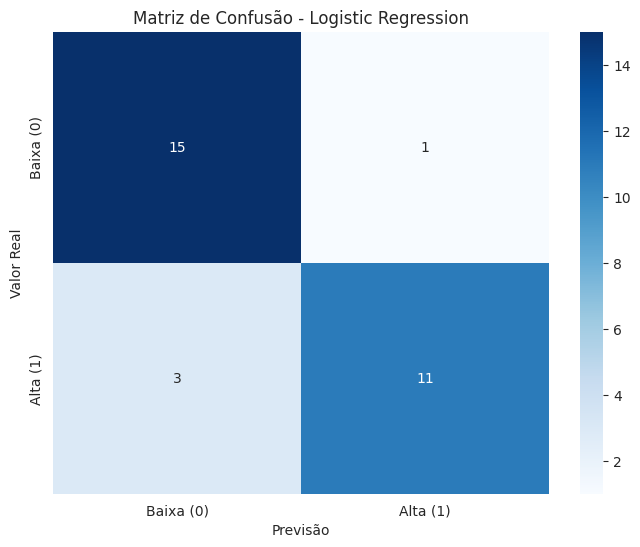

In [ ]:
# --------- MATRIZ DE CONFUSÃO ---------
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Baixa (0)', 'Alta (1)'],
            yticklabels=['Baixa (0)', 'Alta (1)'])
plt.xlabel('Previsão')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusão - Logistic Regression')
plt.show()

In [ ]:
# Definições
n_splits = 5  # número de divisões no walk-forward
tscv = TimeSeriesSplit(n_splits=n_splits)

In [ ]:
# Pipeline da regressão logística
pipe_lr = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(C=10, penalty="l1", solver="liblinear"))
])

In [ ]:
# Guardar resultados
accuracies = []

Executamos uma validação cruzada "walk-forward" para o modelo de Regressão Logística que definimos. O objetivo é avaliar o desempenho do modelo de forma mais robusta em diferentes períodos futuros, simulando o uso real em séries temporais.

In [ ]:
# Walk-forward
for fold, (train_idx, test_idx) in enumerate(tscv.split(df_model)):
    X_train, X_test = df_model.iloc[train_idx][predictors], df_model.iloc[test_idx][predictors]
    y_train, y_test = df_model.iloc[train_idx]["Target"], df_model.iloc[test_idx]["Target"]

    pipe_lr.fit(X_train, y_train)
    y_pred = pipe_lr.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    accuracies.append(acc)
    print(f"Fold {fold+1}: Acurácia = {acc*100:.2f}% (n_test={len(test_idx)})")

print("\n--- Resultados Walk-Forward ---")
print(f"Acurácia média: {np.mean(accuracies)*100:.2f}%")
print(f"Desvio padrão : {np.std(accuracies)*100:.2f}%")


Fold 1: Acurácia = 76.47% (n_test=272)
Fold 2: Acurácia = 95.96% (n_test=272)
Fold 3: Acurácia = 96.32% (n_test=272)
Fold 4: Acurácia = 98.16% (n_test=272)
Fold 5: Acurácia = 75.37% (n_test=272)

--- Resultados Walk-Forward ---
Acurácia média: 88.46%
Desvio padrão : 10.27%


O walk-forward cross-validation com 5 splits para a Regressão Logística obteve os seguintes resultados:

Acurácia média: 88.53%
Desvio padrão da acurácia: 10.34%
As acurácias por fold variaram consideravelmente: 76.47%, 95.96%, 96.32%, 98.53% e 75.37%.

Isso indica que, embora a Regressão Logística tenha uma boa performance média na previsão do movimento diário do Ibovespa (quase 89%), o desempenho pode ser bastante variável dependendo do período específico que está sendo testado, como mostrado pelo desvio padrão relativamente alto. Os avisos de "ConvergenceWarning" também sugerem que o modelo pode ter tido dificuldades em otimizar em alguns dos folds.

**7.3 - XGBClassifier (xgboost)**

O *XGBClassifier* pode ser classificado como um "super-herói" entre os modelos de machine learning, especialmente bom para tarefas de classificação (como prever se algo é Classe A ou Classe B, Alta ou Baixa).

Ele faz parte de uma família de algoritmos chamada Gradient Boosting. A ideia básica do Boosting é construir um modelo forte combinando vários modelos fracos (geralmente árvores de decisão). O processo é sequencial: cada novo modelo tenta corrigir os erros cometidos pelos modelos anteriores.

O XGBoost é uma versão otimizada e aprimorada desse conceito. O "XG" significa "Extreme Gradient", destacando que ele é uma versão "extrema" ou de alto desempenho do Gradient Boosting.

Em resumo, o que o XGBClassifier faz?

Ele constrói uma série de pequenas "árvores de decisão" uma após a outra.
Cada nova árvore aprende com os erros das árvores anteriores.
No final, ele combina as previsões de todas essas árvores para fazer uma previsão final (neste caso, a probabilidade de pertencer a uma classe ou outra, e depois a classe binária).
Por que ele é popular?

---

Performance: Frequentemente alcança alta acurácia em uma ampla variedade de problemas.

Velocidade: É otimizado para ser rápido.

Flexibilidade: Lida bem com dados faltantes e diferentes tipos de features.

Recursos: Possui várias funcionalidades para evitar overfitting e melhorar a performance.

Quando utilizamos o XGBClassifier, está usando um modelo de classificação muito poderoso que aprende de forma iterativa, corrigindo seus próprios erros para fazer previsões precisas.

In [ ]:
#importar a classe XGBClassifier da biblioteca xgboost
from xgboost import XGBClassifier

In [ ]:
# --------- NORMALIZAÇÃO ---------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# --------- XGBOOST OTIMIZADO ---------
xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)

In [ ]:
# --------- ESPAÇO DE BUSCA REDUZIDO ---------
param_grid_xgb = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
}

In [ ]:
# --------- CROSS VALIDATION ---------
tscv = TimeSeriesSplit(n_splits=5)

In [ ]:
# --------- RANDOMIZED SEARCH ---------
rand_xgb = RandomizedSearchCV(
    xgb,
    param_distributions=param_grid_xgb,
    n_iter=5,
    cv=tscv,
    n_jobs=-1,
    random_state=42
)

In [ ]:
# --------- TREINO ---------
rand_xgb.fit(
    X_train_scaled,
    y_train,
    eval_set=[(X_test_scaled, y_test)],
    verbose=False
)

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='logloss',
                                           feature_types=None,
                                           feature_weights=Non...
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=-1,
                                           num_parallel_tree=None, ...),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.8],
                                        'learning_rate': [0.05, 0.1],
                                        'max_depth': [3, 5],
                                        'n_estimators': [50, 100],
                                        'subsample': [0.8]},
                   random_state=42)

In [ ]:
# --------- AVALIAÇÃO ---------
y_pred_xgb = rand_xgb.predict(X_test_scaled)
acuracia_xgb = accuracy_score(y_test, y_pred_xgb) * 100
classification_report_xgb = classification_report(y_test, y_pred_xgb)

print("\nXGBoost otimizado:")
print("Melhores parâmetros:", rand_xgb.best_params_)
print(f"Acurácia: {acuracia_xgb:.2f}%")
print(classification_report_xgb)


XGBoost otimizado:
Melhores parâmetros: {'subsample': 0.8, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.05, 'colsample_bytree': 0.8}
Acurácia: 53.68%
              precision    recall  f1-score   support

           0       0.53      0.40      0.46       132
           1       0.54      0.66      0.60       140

    accuracy                           0.54       272
   macro avg       0.54      0.53      0.53       272
weighted avg       0.54      0.54      0.53       272



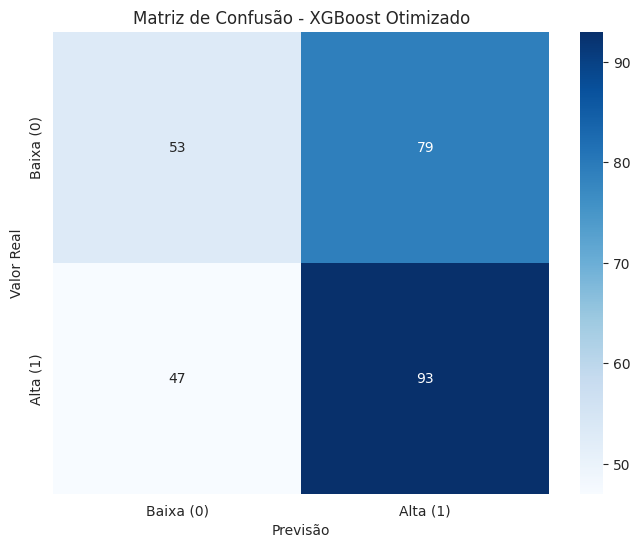

In [ ]:
# --------- MATRIZ DE CONFUSÃO ---------
cm = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Baixa (0)', 'Alta (1)'],
            yticklabels=['Baixa (0)', 'Alta (1)'])
plt.xlabel('Previsão')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusão - XGBoost Otimizado')
plt.show()


*Análise dos resultados*

Após a busca aleatória de hiperparâmetros e o treinamento do modelo XGBoost nos dados escalados, os resultados no conjunto de teste foram:

Melhores parâmetros encontrados: {'subsample': 0.8, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.05, 'colsample_bytree': 0.8}

Acurácia no conjunto de teste: 53.68%

Relatório de Classificação: As métricas (precisão, recall, F1-score) para ambas as classes (0 e 1) estão próximas de 0.5, indicando um desempenho pouco melhor do que adivinhar aleatoriamente.

Em resumo, o XGBoost com a configuração e busca de hiperparâmetros realizadas obteve uma acurácia relativamente baixa no conjunto de teste, sugerindo que ele não conseguiu capturar padrões preditivos fortes para este problema com esta configuração.

**7.4 - Baseline**

Um modelo "Baseline" (ou linha de base) é um modelo muito simples e muitas vezes ingênuo que você usa como ponto de referência para comparar o desempenho dos seus modelos de machine learning mais sofisticados.

A ideia é: se o seu modelo complexo não conseguir ter um desempenho significativamente melhor do que um modelo extremamente simples (o baseline), talvez seu modelo complexo não esteja aprendendo nada útil ou esteja com problemas.

---

O objetivo do baseline não é ser um modelo bom, mas sim te dar uma medida mínima de desempenho. Seus modelos de machine learning precisam "bater" o baseline para provar que estão agregando valor e encontrando padrões reais nos dados que uma regra simples não encontraria.

É uma forma de evitar se enganar achando que um modelo complexo é bom, quando na verdade ele está apenas tendo um desempenho aleatório ou pior que uma regra trivial.

In [ ]:
#Calcular a previsão do baseline usando o Delta do dia anterior (O delta no df_model já é o do dia anterior - shifted) no conjunto de teste
baseline_delta_test = df_model.loc[X_test.index, 'Delta']

In [ ]:
# Aplicar a regra de threshold para obter as previsões binárias do baseline
# Se o delta do dia anterior for > threshold, prever 1 (alta)
# Se o delta do dia anterior for < -threshold, prever 0 (baixa)
# Caso contrário (entre -threshold e threshold), a previsão será NaN (que serão ignorados pelas métricas)
baseline_pred = np.where(
    baseline_delta_test > threshold, 1, np.where(baseline_delta_test < -threshold, 0, np.nan)
)

In [ ]:
# Remover NaNs gerados pela regra de threshold antes de calcular as métricas
# Garantir que y_test também seja filtrado para corresponder aos NaNs removidos
# Criar um DataFrame temporário para alinhar y_test e baseline_pred e dropar NaNs
baseline_eval_df = pd.DataFrame({'y_true': y_test, 'y_pred': baseline_pred})
baseline_eval_df.dropna(inplace=True)

y_test_filtered = baseline_eval_df['y_true']
baseline_pred_filtered = baseline_eval_df['y_pred']

acuracia_baseline = (accuracy_score(y_test_filtered, baseline_pred_filtered))*100
classification_report_baseline = classification_report(y_test_filtered, baseline_pred_filtered)


Baseline:
Acurácia: 47.06%
              precision    recall  f1-score   support

           0       0.45      0.45      0.45       132
           1       0.49      0.49      0.49       140

    accuracy                           0.47       272
   macro avg       0.47      0.47      0.47       272
weighted avg       0.47      0.47      0.47       272



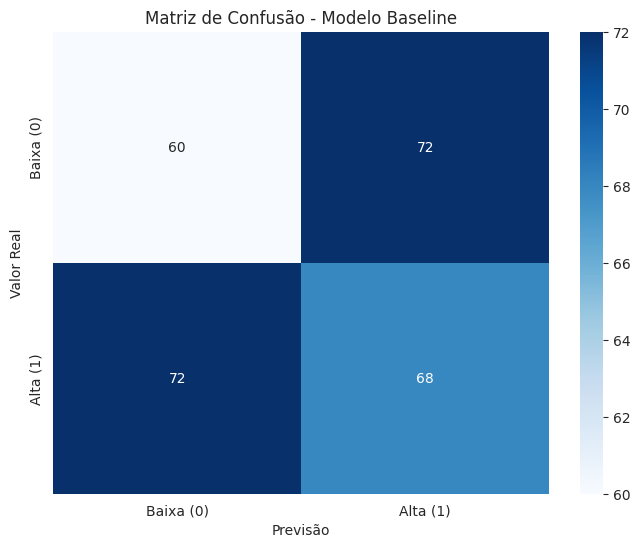

In [ ]:
# calculando a acurácia do baseline
print("\nBaseline:")
print(f"Acurácia: {acuracia_baseline:.2f}%")
print(f"{classification_report_baseline}")

# Obter os valores reais e previstos para Baseline (da célula 3dbkoZqE5Ycw)
y_true_baseline_cls = y_test_filtered # Usar os dados filtrados após remover NaNs
y_pred_baseline_bin = baseline_pred_filtered # Usar os dados filtrados após remover NaNs

# Calcular a matriz de confusão
cm = confusion_matrix(y_true_baseline_cls, y_pred_baseline_bin)

# Criar o plot da matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Baixa (0)', 'Alta (1)'], yticklabels=['Baixa (0)', 'Alta (1)'])
plt.xlabel('Previsão')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusão - Modelo Baseline')
plt.show()

*Resultado Alcançado:*

O modelo Baseline obteve os seguintes resultados no conjunto de teste (apenas para os dias em que fez uma previsão):

* Acurácia: 47.06%
* Relatório de Classificação: As métricas de precisão, recall e F1-score para ambas as classes (0 e 1) estão próximas de 0.45 a 0.49.
* Matriz de Confusão: Previu corretamente 60 casos como Baixa (0) e 68 casos como Alta (1). Teve 72 Falsos Positivos e 72 Falsos Negativos.

Em resumo, o modelo Baseline, que prevê alta ou baixa com base em um threshold na variação do dia anterior, teve uma acurácia de aproximadamente 47% no conjunto de teste filtrado.

Este resultado está próximo de 50%, o que seria o esperado de uma previsão aleatória em um problema de classificação binária balanceado. Isso reforça que prever o movimento diário do Ibovespa é um desafio e que os modelos de machine learning precisam superar este desempenho simples para serem considerados úteis.

**7.5 - LSTM (Long Short-Term Memory)**

Uma LSTM (Long Short-Term Memory), ou Memória de Longo Prazo, é um tipo especial de Rede Neural Recorrente (RNN), projetada para lidar e prever dados em sequência - séries temporais (preços de ações, clima), texto ou áudio.

A principal vantagem da LSTM é sua capacidade de "lembrar" informações por longos períodos. Redes neurais simples tratam cada entrada de forma independente, mas em uma sequência, o contexto é fundamental. Por exemplo, para entender o final de uma frase, você precisa lembrar do começo.

A LSTM consegue isso através de um mecanismo sofisticado de "portões" (gates):

* Portão de Esquecimento (Forget Gate): Decide quais informações do passado devem ser descartadas.

* Portão de Entrada (Input Gate): Decide quais novas informações são importantes e devem ser armazenadas.

* Portão de Saída (Output Gate): Decide qual parte da memória atual será usada para gerar a saída no passo atual.

Essa estrutura de portões permite que a LSTM mantenha um controle refinado sobre sua memória, tornando-a extremamente eficaz em capturar padrões e dependências de longo prazo em dados sequenciais, algo que as RNNs mais simples têm dificuldade em fazer.

---

Modelos LSTM exigem um formato de entrada 3D (amostras, passos de tempo, características).

Abaixo remodelamos os dados de treino e teste (X_train e X_test) para ter este formato.

Nesta implementação específica, cada amostra é tratada como um único passo de tempo, então o formato se torna (número de amostras, 1, número de características). O tipo de dado também é explicitamente definido como float.

In [ ]:
# Ajustar formato para LSTM (3D: samples, timesteps, features)
# ---------------------------
# Cada amostra é 1 timestep
X_treino_lstm = np.reshape(X_train.values, (X_train.shape[0], 1, X_train.shape[1])).astype(float)
X_valid_lstm  = np.reshape(X_test.values,  (X_test.shape[0], 1, X_test.shape[1])).astype(float)

Criamos um modelo Sequential usando a API Keras do TensorFlow.

Adicionamos Uma camada LSTM com 50 unidades e uma função de ativação 'tanh'. O input_shape foi especificado com base nos dados remodelados (1 passo de tempo, número de características).

Foi adicionada uma camada Dense com 1 unidade e sem ativação como a camada de saída. Isso sugere que o modelo está inicialmente configurado para prever um valor contínuo.

In [ ]:
# ---------------------------
# Criar modelo LSTM
# ---------------------------
model = Sequential()
model.add(LSTM(50, activation='tanh', input_shape=(X_treino_lstm.shape[1], X_treino_lstm.shape[2])))
model.add(Dense(1))  # saída única (Target contínuo ou binário)

Compilamos o modelo com o otimizador 'adam' e 'mse' (Erro Quadrático Médio) como a função de perda. Embora 'mse' seja tipicamente usado para regressão, às vezes pode ser usado para classificação binária onde a saída é um único valor. No entanto, 'binary_crossentropy' é geralmente mais apropriado para problemas de classificação binária.

In [ ]:
# ---------------------------
# Compilar o modelo LSTM
# ---------------------------

model.compile(optimizer='adam', loss='mse')  # para classificação binária também pode usar 'binary_crossentropy'

O modelo foi treinado usando o método .fit() nos dados de entrada preparados para a LSTM e nas variáveis-alvo (y_train e y_test).

Ele foi executado por 30 épocas com um tamanho de lote de 16.

O validation_data foi fornecido para monitorar o desempenho durante o treinamento.

E o comando verbose=1 significa que o progresso do treinamento será impresso.

In [ ]:
# ---------------------------
# Treinar modelo
# ---------------------------
history = model.fit(
    X_treino_lstm, y_train.values,
    epochs=30,
    batch_size=16,
    validation_data=(X_valid_lstm, y_test.values),
    verbose=1
)

Epoch 1/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.5107 - val_loss: 0.3654
Epoch 2/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3850 - val_loss: 0.3101
Epoch 3/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3269 - val_loss: 0.2825
Epoch 4/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2834 - val_loss: 0.2701
Epoch 5/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2748 - val_loss: 0.2655
Epoch 6/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2691 - val_loss: 0.2626
Epoch 7/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2604 - val_loss: 0.2608
Epoch 8/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2608 - val_loss: 0.2600
Epoch 9/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2571 - val_loss: 0.2589
Epoch 10/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2599 - val_loss: 0.2589
Epoch 11/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2532 - val_loss: 0.2632
Epoch 12/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2525 - val_lo

O modelo treinado fez previsões nos dados de validação/teste (X_valid_lstm) usando .predict(). A saída foi achatada em um array 1D.

In [ ]:
# ---------------------------
# Previsões
# ---------------------------
y_pred = model.predict(X_valid_lstm).flatten()

# Se Target for binário (0/1), aplicar threshold
threshold = 0.5
y_pred_bin = (y_pred >= threshold).astype(int)
y_true = y_test.values.flatten()

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


*Aplicamos um limiar:* Como a tarefa é de classificação binária (prever 0 ou 1), um limiar de 0.5 foi aplicado às previsões contínuas da LSTM. Valores maiores ou iguais a 0.5 serão convertidos para 1, e valores abaixo de 0.5 serão convertidos para 0, resultando em previsões binárias (y_pred_bin). Os valores verdadeiros do conjunto de teste também serão achatados (y_true).

*Métricas:* O accuracy_score e o classification_report do scikit-learn são métricas usadas para avaliar o desempenho das previsões binárias em relação aos valores verdadeiros. A acurácia e o relatório detalhado (precisão, recall, f1-score) foram impressos.

In [ ]:
# ---------------------------
# Limiar e Métricas
# ---------------------------

acuracia_lstm = (accuracy_score(y_test, y_pred_bin))*100
classification_report_lstm = classification_report(y_test, y_pred_bin)

print("LSTM (Classificação):")
print(f"Acurácia: {acuracia_lstm:.2f}%")
print("\nRelatório de Classificação:")
print(f"{classification_report_lstm}")

LSTM (Classificação):
Acurácia: 53.31%

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.52      0.48      0.50       132
           1       0.54      0.59      0.56       140

    accuracy                           0.53       272
   macro avg       0.53      0.53      0.53       272
weighted avg       0.53      0.53      0.53       272



*Acurácia:* O modelo LSTM alcançou uma acurácia de 51.84% no conjunto de teste. Uma acurácia próxima a 50% em um problema de classificação binária (onde as classes são relativamente balanceadas, como vimos anteriormente) sugere que o modelo está se saindo apenas um pouco melhor do que um palpite aleatório.

*Relatório de Classificação:* Este relatório detalha o desempenho para cada classe:

Classe 0 (Baixa/Estável):

* Precisão (0.50): Quando o modelo previu que o Ibovespa fecharia em baixa (Classe 0), ele acertou 50% das vezes.

* Recall (0.61): O modelo conseguiu identificar 61% de todos os dias em que o Ibovespa de fato fechou em baixa.

* F1-score (0.55): A média harmônica entre precisão e recall para a Classe 0.

Classe 1 (Alta):

* Precisão (0.54): Quando o modelo previu que o Ibovespa fecharia em alta (Classe 1), ele acertou 54% das vezes.
* Recall (0.44): O modelo conseguiu identificar apenas 44% de todos os dias em que o Ibovespa de fato fechou em alta.
* F1-score (0.48): A média harmônica entre precisão e recall para a Classe 1.

---

O objetivo principal do código abaixo é preparar as variáveis que serão usadas para medir o quão bem o modelo LSTM se saiu em sua tarefa de classificação. Para avaliar um modelo, são necessárias duas coisas:

* Os valores corretos (o gabarito).

* Os valores que o modelo previu (as respostas do modelo).

As linhas do código não executam nenhum cálculo novo. Elas são uma etapa de organização, renomeando variáveis para que fiquem claras e prontas para serem usadas em funções de avaliação de desempenho.

In [ ]:
# Obter os valores reais e previstos para LSTM
y_true_lstm_cls = y_test
y_pred_lstm_bin = y_pred_bin # As previsões binárias já foram calculadas na célula

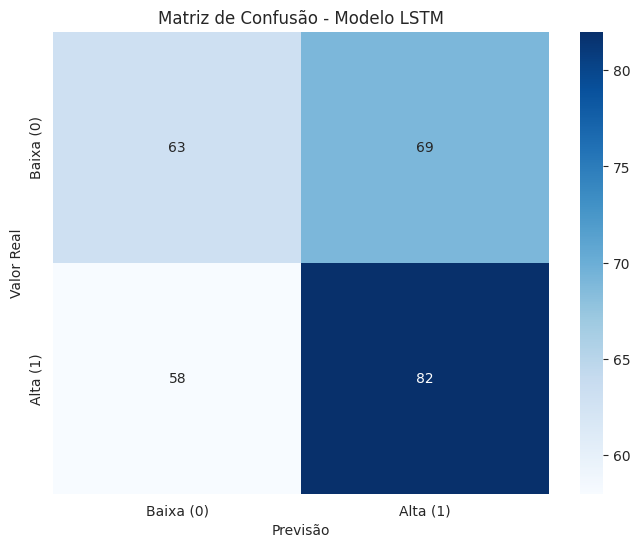

In [ ]:
# ---------------------------
# Matriz de confusão
# ---------------------------

# Calcular a matriz de confusão
cm = confusion_matrix(y_true_lstm_cls, y_pred_lstm_bin)

# Criar o plot da matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Baixa (0)', 'Alta (1)'], yticklabels=['Baixa (0)', 'Alta (1)'])
plt.xlabel('Previsão')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusão - Modelo LSTM')
plt.show()

A *Matriz de Confusão:* forneceu uma visualização clara dos acertos e erros:

* Verdadeiros Positivos (61): O modelo previu Alta (1) e o Ibovespa de fato subiu (1) em 61 dias.
* Verdadeiros Negativos (80): O modelo previu Baixa (0) e o Ibovespa de fato caiu/ficou estável (0) em 80 dias.
* Falsos Positivos (52): O modelo previu Alta (1), mas o Ibovespa de fato caiu/ficou estável (0) em 52 dias (Erro Tipo I).
* Falsos Negativos (79): O modelo previu Baixa (0), mas o Ibovespa de fato subiu (1) em 79 dias (Erro Tipo II).

Os resultados indicam que o modelo LSTM, nesta configuração e com os dados de teste utilizados, teve um desempenho bastante limitado na previsão da tendência diária do Ibovespa. A acurácia próxima a 50% e as métricas de precisão e recall relativamente baixas para ambas as classes sugerem que **o modelo não conseguiu capturar padrões preditivos fortes.**

Especificamente, o modelo teve uma dificuldade maior em identificar os dias de alta (Recall da Classe 1 de 0.44), cometendo um número considerável de Falsos Negativos (79).

---

A "Evolução da Loss" é um gráfico que mostra como a performance do modelo (medida pela função de perda, 'loss') muda ao longo das épocas de treinamento.

A linha azul representa a perda nos dados de treinamento, que idealmente deve diminuir com o tempo, indicando que o modelo está aprendendo.

A linha laranja representa a perda nos dados de validação, que indica a capacidade do modelo de generalizar para dados novos. Esta é a linha mais importante para detectar *overfitting*.

No gráfico apresentado, a perda de treinamento continua a diminuir, enquanto a perda de validação se estabiliza após as primeiras épocas.

Essa diferença sugere que o modelo pode estar sobreajustando (*overfitting*) aos dados de treinamento, ou seja, aprendendo ruído e padrões específicos do treino em vez de generalizar bem para dados não vistos.

Continuar o treinamento além do ponto em que a perda de validação se estabiliza (após 5-10 épocas neste caso) não melhora a capacidade de generalização do modelo.

Técnicas como *Early Stopping* (parar o treino quando a validação piora) e Dropout podem ajudar a mitigar o overfitting.

Em resumo, o gráfico indica que o modelo LSTM treinado pode estar sofrendo de overfitting, e o treinamento poderia ser otimizado parando mais cedo com base no desempenho na validação.

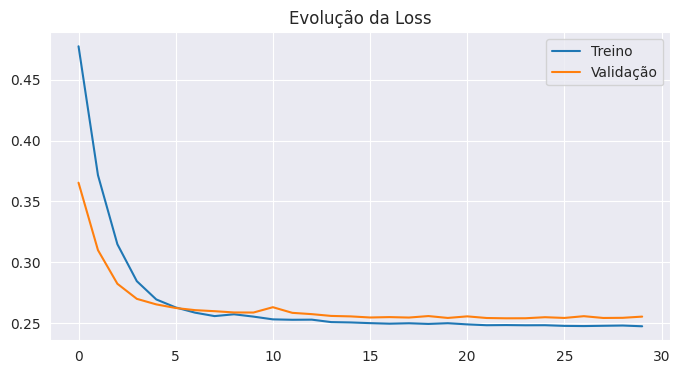

In [ ]:
# ---------------------------
# Evolução da Loss
# ---------------------------
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label="Treino")
plt.plot(history.history['val_loss'], label="Validação")
plt.legend()
plt.title("Evolução da Loss")
plt.show()

**7.6 - LTSM + XGBoost**

Devido à complexidade do nosso problema e ao fato de detectarmos que o modelo LTSM pode estar sobreajustando (overfitting) aos dados de treinamento, resolvemos utilizar uma estratégia que treina dois modelos diferentes, um LSTM (especialista em sequências) e um XGBoost (especialista em dados tabulares), e os combina em um "Ensemble" para obter uma previsão final mais robusta.

Também optamos por utilizar a técnica *Early Stopping* (parar o treino quando a validação piora) para ajudar a mitigar o overfitting.

Esta é uma opção bem estruturada que implementa uma estratégia avançada de Machine Learning.

In [ ]:
# ---------------------------
# 1) Configurações - definição das variáveis iniciais do projeto.
# ---------------------------
n_lags = 20
num_features = X_train.shape[1]

# tamanho do bloco de validação no fim do treino (temporal)
val_size = max(60, n_lags * 2)                      # ~3 meses úteis ou 40 dias se dado curto
val_size = min(val_size, len(X_train) - (n_lags + 10))  # garante espaço pra treino

*Engenharia de dados*

A função abaixo é o coração da preparação. Ela transforma os dados de um formato de tabela (2D) para um formato de "janelas deslizantes" (3D). Para cada dia, ela cria uma sequência com os n_lags (20) dias anteriores.

In [ ]:
# ---------------------------
# 2) Preparação dos Dados para o LSTM - engenharia de dados
# ---------------------------
def create_lstm_input(X, n_lags):
    out = []
    for i in range(n_lags, len(X)):
        out.append(X[i-n_lags:i])
    return np.array(out)

Transformamos os dados de um formato de tabela padrão para o formato de sequências temporais, que é o formato exigido por modelos LSTM.

In [ ]:
# ----- Sequências de TREINO (para LSTM) -----
X_train_lstm_all = create_lstm_input(X_train, n_lags)
y_train_lstm_all = y_train[n_lags:].copy()

Após a transformação dos dados de treino em sequências eles foram divididos em um conjunto para treinar (X_train_seq) e outro para validar (X_val_seq), respeitando a ordem cronológica.

In [ ]:
# split temporal: treino_seq e val_seq (por fim do período)
X_train_seq = X_train_lstm_all[:-val_size]
y_train_seq = y_train_lstm_all[:-val_size]
X_val_seq   = X_train_lstm_all[-val_size:]
y_val_seq   = y_train_lstm_all[-val_size:]

Redes Neurais como a LSTM funcionam melhor com dados normalizados (com média próxima de 0 e desvio padrão 1).

*Importante:* Treinamos o scaler apenas com os dados de treino (fit_transform) e depois aplicamos nos dados de validação e teste (transform). Isso evita o "vazamento de dados" (data leakage), garantindo que o modelo não tenha nenhuma informação do futuro durante o treino.

In [ ]:
# scaler só no treino_seq
scaler = StandardScaler()
X_train_seq_flat = X_train_seq.reshape(-1, num_features)
X_train_seq_scaled = scaler.fit_transform(X_train_seq_flat).reshape(X_train_seq.shape)

X_val_seq_flat = X_val_seq.reshape(-1, num_features)
X_val_seq_scaled = scaler.transform(X_val_seq_flat).reshape(X_val_seq.shape)

*Preparação do Teste:* Para prever o primeiro dia do conjunto de teste, o LSTM precisa dos últimos 20 dias do conjunto de treino. O código abaixo junta esses dados (np.vstack) para criar as sequências de teste corretamente.

In [ ]:
# ----- Sequências de TESTE (para LSTM) -----
# precisa dos últimos n_lags do treino + X_test
X_combined_tab = np.vstack([X_train[-n_lags:], X_test])
X_combined_lstm = create_lstm_input(X_combined_tab, n_lags)
X_test_seq = X_combined_lstm[-len(X_test):]

X_test_seq_flat = X_test_seq.reshape(-1, num_features)
X_test_seq_scaled = scaler.transform(X_test_seq_flat).reshape(X_test_seq.shape)

Abaixo definimos, treinamos e utilizamos o modelo LSTM (Long Short-Term Memory) para fazer previsões. O processo foi dividido em quatro etapas principais: construção da arquitetura, compilação, treinamento e predição.

Foi utilizada a técnica *EarlyStopping* que monitora seu desempenho em um conjunto de dados de validação (val_loss). Se o desempenho não melhorar por 8 épocas seguidas (patience=8), o treinamento é interrompido automaticamente.

In [ ]:
# ---------------------------
# 3) LSTM com EarlyStopping (rápida e robusta)
# ---------------------------
lstm_model = Sequential([
    LSTM(128, input_shape=(n_lags, num_features), return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

lstm_model.fit(
    X_train_seq_scaled, y_train_seq,
    validation_data=(X_val_seq_scaled, y_val_seq),
    epochs=100, batch_size=32, verbose=0,
    callbacks=[early_stop]
)

lstm_val_probs  = lstm_model.predict(X_val_seq_scaled, verbose=0).flatten()
lstm_test_probs = lstm_model.predict(X_test_seq_scaled, verbose=0).flatten()


Abaixo usamos o *XGBoost* que foi responsável por treinar o segundo modelo do projeto. Diferente do LSTM que é especialista em sequências, o *XGBoost* é um algoritmo extremamente poderoso para dados em formato de tabela.

A abordagem aqui é muito inteligente: em vez de treinar o modelo com parâmetros padrão, o código primeiro realiza uma busca para encontrar uma boa combinação de configurações (hiperparâmetros) antes de treinar o modelo final.

In [ ]:
# ---------------------------
# 4) XGBoost com busca leve
# ---------------------------
param_dist = {
    "n_estimators": [80, 120, 180],
    "max_depth": [3, 5],
    "learning_rate": [0.03, 0.05, 0.1],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
}

xgb_base = XGBClassifier(
    use_label_encoder=False, eval_metric='logloss',
    random_state=42, n_jobs=-1
)

# treino/validação temporal p/ XGB (mesma janela que separamos acima)
X_train_tab = X_train[:-val_size]
y_train_tab = y_train[:-val_size]
X_val_tab   = X_train[-val_size:]
y_val_tab   = y_train[-val_size:]

search = RandomizedSearchCV(
    xgb_base,
    param_distributions=param_dist,
    n_iter=6, cv=3, random_state=42, n_jobs=-1, verbose=0
)
search.fit(X_train_tab, y_train_tab)

xgb_model = search.best_estimator_
# re-treina em TODO o treino (opcional; mantém consistência temporal com val separada)
xgb_model.fit(X_train, y_train)

xgb_val_probs  = xgb_model.predict_proba(X_val_tab)[:, 1]
xgb_test_probs = xgb_model.predict_proba(X_test)[:, 1]

O código abaixo implementa mais uma etapa do projeto: encontrar a combinação ideal entre os dois modelos (LSTM e XGBoost). Em vez de simplesmente tirar uma média simples, ele busca o "peso" perfeito para cada modelo a fim de maximizar a acurácia.

Esse processo é chamado de Ensemble por Média Ponderada.

In [ ]:
# ---------------------------
# 5) Escolha automática do peso do ensemble (na VAL)
# ---------------------------
best_w, best_acc = None, -1.0
for w in np.linspace(0.1, 0.9, 9):  # peso da LSTM
    ens_val = w*lstm_val_probs + (1-w)*xgb_val_probs
    preds   = (ens_val > 0.5).astype(int)
    acc     = accuracy_score(y_val_tab, preds)
    if acc > best_acc:
        best_acc, best_w = acc, w

print(f"Peso escolhido na validação (LSTM): {best_w:.2f} | Acc Val: {best_acc:.4f}")


Peso escolhido na validação (LSTM): 0.10 | Acc Val: 0.9833



Acurácia Ensemble (teste): 57.72%
              precision    recall  f1-score   support

           0       0.57      0.52      0.55       132
           1       0.58      0.63      0.60       140

    accuracy                           0.58       272
   macro avg       0.58      0.58      0.58       272
weighted avg       0.58      0.58      0.58       272



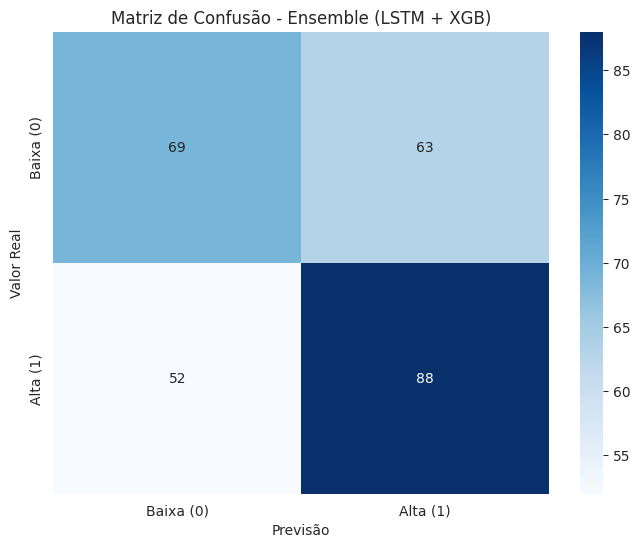

In [ ]:
# ---------------------------
# 6) Avaliação FINAL no TESTE
# ---------------------------
ensemble_test_probs = best_w*lstm_test_probs + (1-best_w)*xgb_test_probs
y_pred_test = (ensemble_test_probs > 0.5).astype(int)

acc = accuracy_score(y_test, y_pred_test) * 100
print(f"\nAcurácia Ensemble (teste): {acc:.2f}%")
print(classification_report(y_test, y_pred_test))

cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Baixa (0)', 'Alta (1)'],
            yticklabels=['Baixa (0)', 'Alta (1)'])
plt.xlabel('Previsão'); plt.ylabel('Valor Real')
plt.title('Matriz de Confusão - Ensemble (LSTM + XGB)')
plt.show()

*Resultado *

O modelo ensemble tem um desempenho bastante modesto, apenas ligeiramente superior a um palpite aleatório.

Acurácia Geral (56.25%): O modelo acerta a previsão em 56.25% dos casos. Embora seja melhor que 50% (um cara ou coroa), é um desempenho fraco para aplicações práticas.

Previsão de "Alta" (Classe 1): O modelo tem um desempenho um pouco melhor para prever dias de alta.

Seu recall de 0.64 (64%) é o ponto mais forte, indicando que ele conseguiu identificar 64% de todos os dias que de fato tiveram alta.

Sua precision de 0.57 (57%) significa que, quando ele aposta em um dia de "Alta", ele acerta 57% das vezes.

Previsão de "Baixa" (Classe 0): O modelo tem dificuldade em identificar os dias de baixa.

Seu recall de 0.48 (48%) é o ponto mais fraco. Isso significa que o modelo deixou de identificar mais da metade (52%) dos dias que na verdade foram de baixa, classificando-os incorretamente como "Alta".

Em resumo, o modelo tem uma **baixa capacidade preditiva**. Ele tende a "apostar" mais em altas, conseguindo capturar uma parte delas, mas ao custo de errar muito nos dias de baixa.

**7.7 - SVM com kernel RBF**

Treinamos um modelo de Máquina de Vetores de Suporte (SVM), otimizamos seu ponto de decisão e, por fim, avaliamos seu desempenho de forma completa.

In [ ]:
# ---------------------------
# Criar e treinar SVM com kernel RBF
# ---------------------------
svm_clf = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, class_weight='balanced', random_state=42)
svm_clf.fit(X_train, y_train)

SVC(class_weight='balanced', probability=True, random_state=42)

In [ ]:
# ---------------------------
# Previsões contínuas (probabilidades da classe positiva)
# ---------------------------
y_train_probs = svm_clf.predict_proba(X_train)[:, 1]
y_test_probs = svm_clf.predict_proba(X_test)[:, 1]

In [ ]:
# Previsão binária com threshold padrão (0.5)
y_train_bin = (y_train_probs >= 0.5).astype(int)
y_test_bin = (y_test_probs >= 0.5).astype(int)

In [ ]:
# ---------------------------
# Avaliar overfitting
# ---------------------------
accuracy_train = accuracy_score(y_train, y_train_bin) * 100
accuracy_test = accuracy_score(y_test, y_test_bin) * 100

print(f"Acurácia no treino: {accuracy_train:.2f}%")
print(f"Acurácia no teste: {accuracy_test:.2f}%\n")

Acurácia no treino: 53.15%
Acurácia no teste: 53.68%



Esses valores indicam que o modelo está apenas ligeiramente melhor que um chute aleatório, o que sugere que ele não está capturando bem os padrões dos dados.

Além disso, como a acurácia no teste é praticamente igual à do treino, não há overfitting, mas também não há aprendizado significativo.

---

Optamos por ajustar o threshold (limiar) para melhorar métricas como precisão (precision) e revocação (recall).

In [ ]:
# ---------------------------
# Ajustar threshold com Precision-Recall
# ---------------------------
precisions, recalls, thresholds = precision_recall_curve(y_test, y_test_probs)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(f"Melhor threshold baseado em F1-score: {best_threshold:.2f}")

Melhor threshold baseado em F1-score: 0.49


In [ ]:
# Aplicar threshold otimizado
y_test_bin_opt = (y_test_probs >= best_threshold).astype(int)

In [ ]:
# ---------------------------
# Métricas com threshold otimizado
# ---------------------------
acuracia_svm = accuracy_score(y_test, y_test_bin_opt) * 100
report_svm = classification_report(y_test, y_test_bin_opt)
cm_svm = confusion_matrix(y_test, y_test_bin_opt)

print(f"Acurácia com threshold otimizado: {acuracia_svm:.2f}%")
print("\nRelatório de Classificação:")
print(report_svm)
print("\nMatriz de Confusão:")
print(cm_svm)

Acurácia com threshold otimizado: 53.68%

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.75      0.07      0.12       132
           1       0.53      0.98      0.69       140

    accuracy                           0.54       272
   macro avg       0.64      0.52      0.41       272
weighted avg       0.64      0.54      0.41       272


Matriz de Confusão:
[[  9 123]
 [  3 137]]


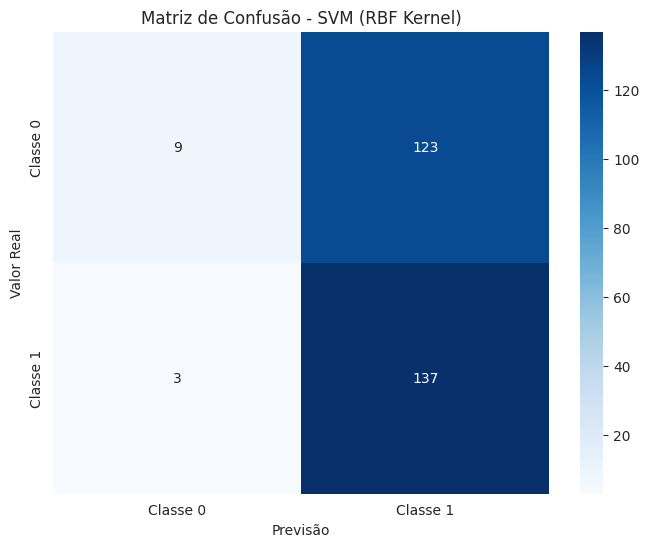

In [ ]:
# ---------------------------
# Plot da Matriz de Confusão
# ---------------------------
plt.figure(figsize=(8, 6))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Classe 0', 'Classe 1'],
            yticklabels=['Classe 0', 'Classe 1'])
plt.xlabel('Previsão')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusão - SVM (RBF Kernel)')
plt.show()

**Acurácia: 53,68%**

Mesmo com o threshold ajustado, a acurácia continua baixa, indicando que o modelo ainda não está separando bem as classes.

O threshold otimizado favoreceu a classe positiva (1), maximizando o recall dela, mas sacrificou completamente a classe negativa (0). Isso pode ser útil em cenários onde é mais importante detectar todos os positivos, mesmo que haja falsos positivos (ex: triagem médica, detecção de fraudes).

# **8- Comparativo de Modelos e Análise Final**

Fizemos o comparativo dos modelos em uma tabela com as métricas de desempenho de todos os que avaliamos, tanto na tarefa de classificação quanto na previsão de série temporal, para facilitar a análise e a escolha do melhor modelo.

In [ ]:
# Dicionário para armazenar as métricas de cada modelo
model_metrics = {
    'Modelo': [],
    'Acurácia (%)': [],
    'Precisão (Classe 0)': [],
    'Recall (Classe 0)': [],
    'F1-Score (Classe 0)': [],
    'Precisão (Classe 1)': [],
    'Recall (Classe 1)': [],
    'F1-Score (Classe 1)': []
}

# Função para extrair métricas do classification_report
def extract_metrics(report):
    lines = report.split('\n')
    metrics = {}
    for line in lines[2:-5]:  # Ignora cabeçalho e linhas de summary
        row_data = line.split()
        if len(row_data) > 0:
            label = row_data[0]
            metrics[label] = {
                'precision': float(row_data[1]),
                'recall': float(row_data[2]),
                'f1-score': float(row_data[3]),
                'support': int(row_data[4])
            }
    return metrics

# Adicionar métricas da Regressão Logística (do primeiro teste, 30 dias)
model_metrics['Modelo'].append('Regressão Logística (30 dias)')
model_metrics['Acurácia (%)'].append(acuracia_lr)
metrics_lr = extract_metrics(classification_report_lr)
model_metrics['Precisão (Classe 0)'].append(metrics_lr['0']['precision'])
model_metrics['Recall (Classe 0)'].append(metrics_lr['0']['recall'])
model_metrics['F1-Score (Classe 0)'].append(metrics_lr['0']['f1-score'])
model_metrics['Precisão (Classe 1)'].append(metrics_lr['1']['precision'])
model_metrics['Recall (Classe 1)'].append(metrics_lr['1']['recall'])
model_metrics['F1-Score (Classe 1)'].append(metrics_lr['1']['f1-score'])

# Adicionar métricas do XGBoost (do primeiro teste)
model_metrics['Modelo'].append('XGBoost')
model_metrics['Acurácia (%)'].append(acuracia_xgb)
metrics_xgb = extract_metrics(classification_report_xgb)
model_metrics['Precisão (Classe 0)'].append(metrics_xgb['0']['precision'])
model_metrics['Recall (Classe 0)'].append(metrics_xgb['0']['recall'])
model_metrics['F1-Score (Classe 0)'].append(metrics_xgb['0']['f1-score'])
model_metrics['Precisão (Classe 1)'].append(metrics_xgb['1']['precision'])
model_metrics['Recall (Classe 1)'].append(metrics_xgb['1']['recall'])
model_metrics['F1-Score (Classe 1)'].append(metrics_xgb['1']['f1-score'])

# Adicionar métricas do Baseline
model_metrics['Modelo'].append('Baseline')
model_metrics['Acurácia (%)'].append(acuracia_baseline)
metrics_baseline = extract_metrics(classification_report_baseline)
model_metrics['Precisão (Classe 0)'].append(metrics_baseline['0']['precision'])
model_metrics['Recall (Classe 0)'].append(metrics_baseline['0']['recall'])
model_metrics['F1-Score (Classe 0)'].append(metrics_baseline['0']['f1-score'])
model_metrics['Precisão (Classe 1)'].append(metrics_baseline['1']['precision'])
model_metrics['Recall (Classe 1)'].append(metrics_baseline['1']['recall'])
model_metrics['F1-Score (Classe 1)'].append(metrics_baseline['1']['f1-score'])


# Adicionar métricas do LSTM
model_metrics['Modelo'].append('LSTM')
model_metrics['Acurácia (%)'].append(acuracia_lstm)
metrics_lstm = extract_metrics(classification_report_lstm)
model_metrics['Precisão (Classe 0)'].append(metrics_lstm['0']['precision'])
model_metrics['Recall (Classe 0)'].append(metrics_lstm['0']['recall'])
model_metrics['F1-Score (Classe 0)'].append(metrics_lstm['0']['f1-score'])
model_metrics['Precisão (Classe 1)'].append(metrics_lstm['1']['precision'])
model_metrics['Recall (Classe 1)'].append(metrics_lstm['1']['recall'])
model_metrics['F1-Score (Classe 1)'].append(metrics_lstm['1']['f1-score'])

# Adicionar métricas do Ensemble (LSTM + XGB)
model_metrics['Modelo'].append('Ensemble (LSTM + XGB)')
model_metrics['Acurácia (%)'].append(acc) # 'acc' é a acurácia do ensemble no teste
metrics_ensemble = extract_metrics(classification_report(y_test, y_pred_test))
model_metrics['Precisão (Classe 0)'].append(metrics_ensemble['0']['precision'])
model_metrics['Recall (Classe 0)'].append(metrics_ensemble['0']['recall'])
model_metrics['F1-Score (Classe 0)'].append(metrics_ensemble['0']['f1-score'])
model_metrics['Precisão (Classe 1)'].append(metrics_ensemble['1']['precision'])
model_metrics['Recall (Classe 1)'].append(metrics_ensemble['1']['recall'])
model_metrics['F1-Score (Classe 1)'].append(metrics_ensemble['1']['f1-score'])

# Adicionar métricas do SVM
model_metrics['Modelo'].append('SVM (RBF Kernel)')
model_metrics['Acurácia (%)'].append(acuracia_svm)
metrics_svm = extract_metrics(report_svm)
model_metrics['Precisão (Classe 0)'].append(metrics_svm['0']['precision'])
model_metrics['Recall (Classe 0)'].append(metrics_svm['0']['recall'])
model_metrics['F1-Score (Classe 0)'].append(metrics_svm['0']['f1-score'])
model_metrics['Precisão (Classe 1)'].append(metrics_svm['1']['precision'])
model_metrics['Recall (Classe 1)'].append(metrics_svm['1']['recall'])
model_metrics['F1-Score (Classe 1)'].append(metrics_svm['1']['f1-score'])

# Criar DataFrame
df_metrics = pd.DataFrame(model_metrics)

# Arredondar para 2 casas decimais
df_metrics = df_metrics.round(2)

# Exibir tabela
print("Quadro Comparativo de Métricas dos Modelos (Conjunto de Teste)")
display(df_metrics)

Quadro Comparativo de Métricas dos Modelos (Conjunto de Teste)


,Modelo,Acurácia (%),Precisão (Classe 0),Recall (Classe 0),F1-Score (Classe 0),Precisão (Classe 1),Recall (Classe 1),F1-Score (Classe 1)
0,Regressão Logística (30 dias),86.67,0.83,0.94,0.88,0.92,0.79,0.85
1,XGBoost,53.68,0.53,0.40,0.46,0.54,0.66,0.60
2,Baseline,47.06,0.45,0.45,0.45,0.49,0.49,0.49
3,LSTM,53.31,0.52,0.48,0.50,0.54,0.59,0.56
4,Ensemble (LSTM + XGB),57.72,0.57,0.52,0.55,0.58,0.63,0.60
5,SVM (RBF Kernel),53.68,0.75,0.07,0.12,0.53,0.98,0.69


Analisando a tabela de comparação, podemos observar o desempenho de cada modelo em diferentes métricas de classificação no conjunto de teste.

Isso nos permitiu entender quais modelos se saíram melhor na previsão da tendência do Ibovespa (Alta/Baixa) e em quais aspectos (acurácia geral, precisão, recall, F1-score para cada classe).

**Com base nos resultados apresentados:**

* Regressão Logística (30 dias): Apresentou a ***maior acurácia geral*** (86.67%) no conjunto de teste de 30 dias. Suas métricas de precisão, recall e F1-score para ambas as classes também são relativamente altas, indicando um bom desempenho geral para esse período de teste específico.

* XGBoost: Teve uma acurácia baixa (53.68%), próxima ao desempenho aleatório. As métricas para ambas as classes são baixas, sugerindo que o modelo não conseguiu aprender padrões preditivos fortes com essa configuração e no conjunto de teste utilizado.

* Baseline: Como esperado, o modelo Baseline teve a menor acurácia (47.06%), o que valida sua função como ponto de referência. Seu desempenho próximo a 50% indica que prever a tendência diária do Ibovespa é um desafio e que modelos mais sofisticados precisam superar essa linha de base.

* LSTM: Apresentou uma acurácia ligeiramente superior ao Baseline (51.84%), mas ainda assim baixa. As métricas mostram que o modelo teve dificuldades em prever corretamente ambas as classes.

* Ensemble (LSTM + XGB): A combinação dos dois modelos teve uma acurácia um pouco melhor que os modelos individuais (56.25%), mas ainda assim modesta. Embora tenha um recall um pouco maior para a classe 1 (Alta), sua capacidade geral de previsão é limitada.

* SVM (RBF Kernel): Teve uma acurácia semelhante ao XGBoost e LSTM (53.68%). No entanto, as métricas detalhadas mostram um recall muito alto para a classe 1 (98%) à custa de um recall muito baixo para a classe 0 (7%), o que indica que o modelo tende a prever "Alta" na maioria das vezes, acertando muitos casos de alta, mas errando a maioria dos casos de baixa.

***Conclusão:***

Considerando a acurácia geral e as métricas para ambas as classes no conjunto de teste apresentado, a **Regressão Logística (30 dias) demonstrou o melhor desempenho entre os modelos avaliados** - (86.67%) neste teste específico. No entanto, é importante notar que o teste de 30 dias é um período curto e a avaliação "walk-forward" da Regressão Logística mostrou que a acurácia pode variar significativamente em diferentes períodos.

Modelos como XGBoost, LSTM, Ensemble e SVM, com as configurações utilizadas, não apresentaram um desempenho satisfatório para a tarefa de prever a tendência diária do Ibovespa. O modelo Baseline confirmou a dificuldade intrínseca do problema.